In [585]:
import argparse
import os
import pickle
import time
from itertools import product
from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb

import numpy as np

from tqdm.auto import tqdm

from dynamics import prior, disturbance, plant
from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

from functools import partial
import matplotlib.pyplot as plt
import csv

plt.rcParams.update({'font.size': 24})

In [586]:
def convert_p_qbar(p):
    return np.sqrt(1/(1 - 1/p) - 1.1)

def convert_qbar_p(qbar):
    return 1/(1 - 1/(1.1 + qbar**2))

In [587]:
def eval_single_model(model_dir, filename, T, dt, w, pnorm_flag=True, visual_verbose=0, save_dir=None, fixed_P=None, controller_type='adaptive'):
    model_pkl_loc = os.path.join(model_dir, filename)
    with open(model_pkl_loc, 'rb') as f:
        train_results = pickle.load(f)

    test_results = {}
    test_params = {}  

    parts = filename.replace('.pkl', '').split('_')
        
    # Dictionary to hold the attributes for this file
    test_results['train_params'] = {}
    # Loop through each part of the filename
    for part in parts:
        # Split each part by '=' to separate the key and value
        key, value = part.split('=')
        # Convert value to float if it looks like a number, else keep as string
        try:
            test_results['train_params'][key] = float(value)
        except ValueError:
            test_results['train_params'][key] = value

    # Post-process training loss information
    # train_aux = train_results['train_lossaux_history']
    # train_loss_history = jnp.zeros(train_results['train_params']['E'])
    # for i in range(test_results['train_params']['E']):
    #     train_loss_history[i] = train_aux[i]['tracking_loss'] + 1e-3 * train_aux[i]['control_loss'] + 1e-4 * train_aux[i]['l2_penalty'] + test_results['train_params']['regP'] * train_aux[i]['reg_P_penalty']

    if not pnorm_flag:
        test_results['train_info'] = {
            # 'best_step_meta': train_results['best_step_meta'],
            'ensemble': train_results['ensemble'],
            # 'valid_loss_history': train_results['valid_loss_history'],
            # 'train_loss_history': train_results['train_loss_history'],
            # 'pnorm_history': train_results['pnorm_history']
        }
    else:
        test_results['train_info'] = {
            'best_step_meta': train_results['best_step_meta'],
            'ensemble': train_results['ensemble'],
            'valid_loss_history': train_results['valid_loss_history'],
            # 'train_loss_history': train_results['train_loss_history'],
            'pnorm_history': train_results['pnorm_history'],
            'ensemble_loss': train_results['ensemble_loss']
        }
    # test_results['train_info']['pnorm_history'].prepend(test_results['train_params']['pinit'])

    if pnorm_flag:
        test_results['final_p'] = train_results['pnorm']
        # Note that the pnorm stored in pickle is the actual p
        # To run evaluation script, we convert params['pnorm'] to qbar
        test_params['pnorm'] = convert_p_qbar(train_results['pnorm'])
    else:
        test_results['final_p'] = 2.0
    

    # Store the model parameters
    test_params['W'] = train_results['model']['W']
    test_params['b'] = train_results['model']['b']
    test_params['Λ'] = params_to_posdef(train_results['controller']['Λ'])
    test_params['K'] = params_to_posdef(train_results['controller']['K'])
    if fixed_P is None:
        test_params['P'] = params_to_posdef(train_results['controller']['P'])
    else:
        # P_size = params_to_posdef(train_results['controller']['P']).shape[0]
        # test_params['P'] = jnp.eye(P_size) * fixed_P
        # test_params['P'] = 1e-1*jnp.eye(32)
        test_params['P'] = fixed_P*jnp.eye(32)
    
    print('Λ:', test_params['Λ'])
    print('K:', test_params['K'])
    print('P:', test_params['P'])
    print('eig_Ps:', jnp.linalg.eigh(test_params['P'])[0])

    test_params['ensemble'] = {
        'W': train_results['ensemble']['W'],
        'b': train_results['ensemble']['b'],
        'A': train_results['ensemble']['A']
    }

    # Test on new trajectories
    ts = jnp.arange(0, T, dt)
    sim = test_simulate(ts, w, test_params, reference, NGD_flag=pnorm_flag, controller_type=controller_type)

    sim_e = sim['q'] - sim['r']
    tracking_error = jnp.mean(jnp.linalg.norm(sim_e, axis=1))
    sim_ftilde = sim['f_hat'] - sim['f_ext']
    estimation_error = jnp.mean(jnp.linalg.norm(sim_ftilde, axis=1))

    test_results['tracking_err'] = tracking_error
    test_results['estimation_err'] = estimation_error

    if os.path.exists(os.path.join(model_dir, 'figs')) == False:
        os.makedirs(os.path.join(model_dir, 'figs'))
        
    if visual_verbose > 0:
        if pnorm_flag:
            fig, ax = plt.subplots(1, 3, figsize=(20, 10))
            if test_results['train_params']['pfreq'] > test_results['train_params']['E']:
                ax[0].axhline(test_results['final_p'], 0, test_results['train_params']['E'], label='final p')
            else:
                ax[0].step(np.arange(0, test_results['train_params']['E'], test_results['train_params']['pfreq']), test_results['train_info']['pnorm_history'])
            ax[0].set_ylabel('p')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('p_init = {}'.format(test_results['train_params']['pinit']))

            ax[1].plot(range(int(test_results['train_params']['E'])), test_results['train_info']['valid_loss_history'])
            ax[1].set_title('Validation Loss')
            ax[1].set_ylabel('Val Loss')
            ax[1].set_xlabel('Epochs')

            ax[2].plot(range(int(test_results['train_params']['E'])), test_results['train_info']['ensemble_loss'])
            ax[2].set_title('Ensemble Loss')
            ax[2].set_ylabel('Ensemble Loss')
            ax[2].set_xlabel('Epochs')

            fig.tight_layout()
            fig.savefig(os.path.join(model_dir, 'figs/train_info_{}'.format(filename.replace('.pkl', '.png'))))
            # plt.close(fig)

        if visual_verbose > 1:
            fig, ax = plt.subplots(1, 3, figsize=(30, 10))
            ax[0].plot(ts, sim['q'][:, 0], 'r-', label='q')
            ax[0].plot(ts, sim['r'][:, 0], 'b--', label='r')
            ax[0].set_ylabel('x')
            ax[0].set_xlabel('t')
            ax[0].legend()

            ax[1].plot(ts, sim['q'][:, 1], 'r-', label='q')
            ax[1].plot(ts, sim['r'][:, 1], 'b--', label='r')
            ax[1].set_ylabel('y')
            ax[1].set_xlabel('t')
            ax[1].legend()

            ax[2].plot(ts, sim['q'][:, 2], 'r-', label='q')
            ax[2].plot(ts, sim['r'][:, 2], 'b--', label='r')
            ax[2].set_ylabel('z')
            ax[2].set_xlabel('t')
            ax[2].legend()

            fig.tight_layout()
            fig.savefig(os.path.join(model_dir, 'figs/tracking_{}'.format(filename.replace('.pkl', '.png'))))
            # plt.close(fig)
            if visual_verbose > 2:
                fig, ax = plt.subplots(1, 3, figsize=(30, 10))
                ax[0].plot(ts, sim['f_hat'][:, 0], 'r-', label='f_hat')
                ax[0].plot(ts, sim['f_ext'][:, 0], 'b--', label='f_ext')
                ax[0].set_ylabel('f_x')
                # ax[0].set_ylim([-20, 20])
                ax[0].set_xlabel('t')
                ax[0].legend()

                ax[1].plot(ts, sim['f_hat'][:, 1], 'r-', label='f_hat')
                ax[1].plot(ts, sim['f_ext'][:, 1], 'b--', label='f_ext')
                ax[1].set_ylabel('f_y')
                # ax[1].set_ylim([-20, 20])
                ax[1].set_xlabel('t')
                ax[1].legend()

                ax[2].plot(ts, sim['f_hat'][:, 2], 'r-', label='f_hat')
                ax[2].plot(ts, sim['f_ext'][:, 2], 'b--', label='f_ext')
                ax[2].set_ylabel('f_z')
                # ax[2].set_ylim([-20, 20])
                ax[2].set_xlabel('t')
                ax[2].legend()

                fig.tight_layout()
                fig.savefig(os.path.join(model_dir, 'figs/estimation_{}'.format(filename.replace('.pkl', '.png'))))
                # plt.close(fig)
                if visual_verbose > 3:
                    fig, ax = plt.subplots(1, 3, figsize=(30, 10))
                    ax[0].plot(ts, sim['u'][:, 0], 'r-', label='u')
                    ax[0].plot(ts, sim['u_d'][:, 0], 'b--', label='u_d')
                    ax[0].set_ylabel('u_x')
                    ax[0].set_xlabel('t')
                    ax[0].legend()

                    ax[1].plot(ts, sim['u'][:, 1], 'r-', label='u')
                    ax[1].plot(ts, sim['u_d'][:, 1], 'b--', label='u_d')
                    ax[1].set_ylabel('u_y')
                    ax[1].set_xlabel('t')
                    ax[1].legend()

                    ax[2].plot(ts, sim['u'][:, 2], 'r-', label='u')
                    ax[2].plot(ts, sim['u_d'][:, 2], 'b--', label='u_d')
                    ax[2].set_ylabel('u_z')
                    ax[2].set_xlabel('t')
                    ax[2].legend()

                    fig.tight_layout()
                    fig.savefig(os.path.join(model_dir, 'figs/control_input_{}'.format(filename.replace('.pkl', '.png'))))
                    # plt.close(fig)
                    if visual_verbose > 4:
                        R_quat = jax.vmap(flat_rotation_matrix_to_quaternion)(sim['R_flatten'])
                        R_d_quat = jax.vmap(flat_rotation_matrix_to_quaternion)(sim['R_d_flatten'])

                        fig, ax = plt.subplots(1, 4, figsize=(30, 10))
                        ax[0].plot(ts, R_quat[:, 0], label='R')
                        ax[0].plot(ts, R_d_quat[:, 0], label='R_d')
                        ax[0].set_ylabel('q_w')
                        ax[0].set_xlabel('t')
                        ax[0].legend()

                        ax[1].plot(ts, R_quat[:, 1], label='R')
                        ax[1].plot(ts, R_d_quat[:, 1], label='R_d')
                        ax[1].set_ylabel('q_x')
                        ax[1].set_xlabel('t')
                        ax[1].legend()

                        ax[2].plot(ts, R_quat[:, 2], label='R')
                        ax[2].plot(ts, R_d_quat[:, 2], label='R_d')
                        ax[2].set_ylabel('q_y')
                        ax[2].set_xlabel('t')
                        ax[2].legend()

                        ax[3].plot(ts, R_quat[:, 3], label='R')
                        ax[3].plot(ts, R_d_quat[:, 3], label='R_d')
                        ax[3].set_ylabel('q_z')
                        ax[3].set_xlabel('t')
                        ax[3].legend()

                        fig.tight_layout()
                        fig.savefig(os.path.join(model_dir, 'figs/R_d_{}'.format(filename.replace('.pkl', '.png'))))
                        # plt.close(fig)
                        if visual_verbose > 5:
                            y = jnp.linalg.norm(sim['y'], axis=1)
                            A = jnp.linalg.norm(sim['A'], axis=1)

                            fig, ax = plt.subplots(1, 2, figsize=(30, 10))
                            ax[0].plot(ts, y, label='y')
                            ax[0].set_ylabel('y')
                            ax[0].set_xlabel('t')
                            ax[0].legend()

                            ax[1].plot(ts, A, label='A')
                            ax[1].set_ylabel('A')
                            ax[1].set_xlabel('t')
                            ax[1].legend()

                            fig.tight_layout()
                            fig.savefig(os.path.join(model_dir, 'figs/A_y_{}'.format(filename.replace('.pkl', '.png'))))
                            # plt.close(fig)

    sim['ts'] = ts
    test = {
            'sim': sim,
            'params': test_params,
            'results': test_results,
            }
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        with open(os.path.join(save_dir, 'test_' + filename), 'wb') as f:
            pickle.dump(test, f)

    return sim, test_params, test_results

In [588]:
def validate_model(raw, epoch_i, print_=False, plot=False):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']
    num_refs = hparams['meta']['num_refs']
    coefs = raw['coefs']
    max_ref = raw['max_ref']
    min_ref = raw['min_ref']
    t_knots = raw['t_knots']

    A = raw['train_lossaux_history'][epoch_i]['A']
    # W = raw['train_lossaux_history'][epoch_i]['W']
    # b = raw['train_lossaux_history'][epoch_i]['b']
    eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
    eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
    eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
    control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
    estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
    tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
    l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
    reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
    pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
    x = raw['train_lossaux_history'][epoch_i]['x']

    mystery_i = 0

    if plot:
        def reference(t):
            # print([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs])
            r = jnp.array([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs]) + jnp.array([0, 0, 1])
            r = jnp.clip(r, min_ref, max_ref)
            return r

        num_steps = int(np.maximum(np.abs((T - 0)/dt), 1))
        ts = jnp.linspace(0, T, num_steps + 1)
        r = jax.vmap(reference)(ts)
        dr = jax.vmap(jax.jacfwd(reference))(ts)

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 0], 'r-', label='q')
        ax[0].plot(ts, r[:, 0], 'b--', label='r')
        ax[0].set_ylabel('x')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 1], 'r-', label='q')
        ax[1].plot(ts, r[:, 1], 'b--', label='r')
        ax[1].set_ylabel('y')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 2], 'r-', label='q')
        ax[2].plot(ts, r[:, 2], 'b--', label='r')
        ax[2].set_ylabel('z')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Position')
        fig.tight_layout()

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 3], 'r-', label='dq')
        ax[0].plot(ts, dr[:, 0], 'b--', label='dr')
        ax[0].set_ylabel('dx')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 4], 'r-', label='dq')
        ax[1].plot(ts, dr[:, 1], 'b--', label='dr')
        ax[1].set_ylabel('dy')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 5], 'r-', label='dq')
        ax[2].plot(ts, dr[:, 2], 'b--', label='dr')
        ax[2].set_ylabel('dz')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Velocity')
        fig.tight_layout()

        A_norm = jnp.linalg.norm(A, axis=(1,2))

        fig, ax = plt.subplots(1, 2, figsize=(30, 10))

        ax[0].plot(ts, A_norm, label='A')
        ax[0].set_ylabel('A')
        ax[0].set_xlabel('t')
        ax[0].legend()

    num_models = len(control_loss)

    control_loss = jnp.sum(control_loss)
    estimation_loss = jnp.sum(estimation_loss)
    tracking_loss = jnp.sum(tracking_loss)

    normalizer = T * num_refs * num_models

    regularizer_l2 = hparams['meta']['regularizer_l2']
    regularizer_ctrl = hparams['meta']['regularizer_ctrl']
    regularizer_error = hparams['meta']['regularizer_error']
    regularizer_P = hparams['meta']['regularizer_P']

    loss = (tracking_loss
                + regularizer_ctrl*control_loss
                + regularizer_error*estimation_loss
                + regularizer_l2*l2_penalty
                ) / normalizer + regularizer_P * reg_P_penalty

    # total_loss_norm = loss
    tracking_loss_norm = tracking_loss/normalizer
    control_loss_norm = regularizer_ctrl*control_loss/normalizer
    estimation_loss_norm = regularizer_error*estimation_loss/normalizer
    l2_penalty_norm = regularizer_l2*l2_penalty/normalizer
    reg_P_penalty_norm = regularizer_P*reg_P_penalty

    if print_:
        print('\nLoss at epoch:', epoch_i)
        print('\tTraining loss:                   ', loss)
        print('\tNormalized tracking_loss_norm:   ', tracking_loss_norm)
        print('\tNormalized control_loss_norm:    ', control_loss_norm)
        print('\tNormalized l2_penalty_norm:      ', l2_penalty_norm)
        print('\tNormalized reg_P_penalty_norm:   ', reg_P_penalty_norm)

        print('\nEigenvalues of P:', eigs_P)
        # print('eigs_Λ:', eigs_Λ)
        # print('eigs_K:', eigs_K)

    return loss, tracking_loss_norm, control_loss_norm, reg_P_penalty_norm, l2_penalty_norm

def plot_losses(raw, xlim=[0, 1000], ylim=None):
    total_losses = []
    tracking_losses = []
    control_losses = []
    reg_P_penalties = []
    E = int(raw['hparams']['ensemble']['num_epochs'])
    for epoch_i in range(E):
        losses = validate_model(raw, epoch_i, print_=False, plot=False)
        total_losses.append(losses[0])
        tracking_losses.append(losses[1])
        control_losses.append(losses[2])
        reg_P_penalties.append(losses[3])

    fig, ax = plt.subplots(1, 4, figsize=(30, 10))
    ax[0].plot(range(E), total_losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    if ylim:
        ax[0].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    ax[0].set_title('Training Loss')

    ax[1].plot(range(E), tracking_losses)
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    if ylim:
        ax[1].set_ylim(ylim)
    ax[1].set_xlim(xlim)
    ax[1].set_title('Tracking Loss')

    ax[2].plot(range(E), control_losses)
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Epoch')
    if ylim:
        ax[2].set_ylim(ylim)
    ax[2].set_xlim(xlim)
    ax[2].set_title('Control Loss')

    ax[3].plot(range(E), reg_P_penalties)
    ax[3].set_ylabel('Loss')
    ax[3].set_xlabel('Epoch')
    if ylim:
        ax[3].set_ylim(ylim)
    ax[3].set_xlim(xlim)
    ax[3].set_title('reg_P_penalty')

    # print(total_losses[-1])
    # print(tracking_losses[-1])
    # print(control_losses[-1])
    # print(reg_P_penalties[-1])
    # fig.suptitle(f'Losses')
    fig.tight_layout()

In [589]:
# Support functions for generating loop reference trajectory
# def reference(t):
#     T = 5.            # loop period
#     d = 2.             # displacement along `x` from `t=0` to `t=T`
#     w = 2.             # loop width
#     h = 3.             # loop height
#     ϕ_max = jnp.pi/3   # maximum roll angle (achieved at top of loop)

#     x = (w/2)*jnp.sin(2*jnp.pi * t/T) + d*(t/T)
#     y = (h/2)*(1 - jnp.cos(2*jnp.pi * t/T))
#     ϕ = 4*ϕ_max*(t/T)*(1-t/T)
#     r = jnp.array([x, y, ϕ])
#     return r

seed = 0
key = jax.random.PRNGKey(seed)

xmin_ = -4.25
xmax_ = 4.5
ymin_ = -3.5
ymax_ = 4.25
zmin_ = 0.0
zmax_ = 2.0

T = 30
num_knots = 6
poly_orders = (9, 9, 9)
deriv_orders = (4, 4, 4)
min_step = jnp.array([-2, -2, -0.25])
max_step = jnp.array([2, 2, 0.25])
min_knot = jnp.array([xmin_, ymin_, zmin_-1])
max_knot = jnp.array([xmax_, ymax_, zmax_-1])

key, *subkeys = jax.random.split(key, 2)
subkeys = jnp.vstack(subkeys)
# in_axes = (0, None, None, None, None, None, None, None, None)
t_knots, knots, coefs = random_ragged_spline(
    subkeys, T, num_knots, poly_orders, deriv_orders,
    min_step, max_step, min_knot, max_knot
    )
def reference(t):
    x_coefs, y_coefs, z_coefs = coefs
    x = spline(t, t_knots, x_coefs)
    y = spline(t, t_knots, y_coefs)
    z = spline(t, t_knots, z_coefs) + 1.
    x = jnp.clip(x, xmin_, xmax_)
    y = jnp.clip(y, ymin_, ymax_)
    z = jnp.clip(z, zmin_, zmax_)
    r = jnp.array([x, y, z])
    return r

def odeint_fixed_step(func, x0, t0, t1, step_size, *args):
    """TODO: docstring."""
    # Use `numpy` for purely static operations on static arguments
    # (see: https://github.com/google/jax/issues/5208)
    # jdebug.print('{t1_type}', t1_type=type(t1))
    num_steps = 10

    ts = jnp.linspace(t0, t1, num_steps + 1)
    xs = odeint_ckpt(func, x0, ts, *args)
    return xs, ts

In [590]:
def ensemble_disturbance(q, dq, R_flatten, Omega, W, b, A):
    test_i = 0
    f_ext = jnp.concatenate((q, dq, R_flatten, Omega), axis=0)
    for W, b in zip(W, b):
        f_ext = jnp.tanh(W[test_i]@f_ext + b[test_i])
    f_ext = A[test_i] @ f_ext
    return 5*f_ext
    
    # f_ext = 3*jnp.array([-q[1]**2, -q[2]**2, -q[0]**2])
    # return f_ext

    # f_ext = 3*jnp.array([q[0]**2, q[1]**2, q[2]**2])
    # return f_ext

    # return jnp.array([0, 0, 0])

k_R = jnp.array([1.4, 1.4, 1.26])
# k_R = jnp.array([4.250, 4.250, 0.300])*2
# k_R = jnp.array([5.0, 5.0, 4.0])
k_Omega = jnp.array([0.330, 0.330, 0.300])
J = jnp.diag(jnp.array([0.03, 0.03, 0.09]))

def plant_attitude(R_flatten, Omega, u_d):
    R = R_flatten.reshape((3,3))

    # f_d = jnp.linalg.norm(u)
    b_3d = u_d / jnp.linalg.norm(u_d)
    b_1d = jnp.array([1, 0, 0])
    cross = jnp.cross(b_3d, b_1d)
    b_2d = cross / jnp.linalg.norm(cross)

    R_d = jnp.column_stack((jnp.cross(b_2d, b_3d), b_2d, b_3d))

    Omega_d = jnp.array([0, 0, 0])
    dOmega_d = jnp.array([0, 0, 0])

    e_R = 0.5 * vee(R_d.T@R - R.T@R_d)
    e_Omega = Omega - R.T@R_d@Omega_d

    M = - k_R*e_R \
        - k_Omega*e_Omega \
        + jnp.cross(Omega, J@Omega) \
        - J@(hat(Omega)@R.T@R_d@Omega_d - R.T@R_d@dOmega_d)

    dOmega = jax.scipy.linalg.solve(J, M - jnp.cross(Omega, J@Omega), assume_a='pos')
    dR = R@hat(Omega)
    dR_flatten = dR.flatten()

    return (dR_flatten, dOmega)

In [591]:
def test_simulate(ts, w, params, reference,
                plant=plant, prior=prior, ensemble_disturbance=ensemble_disturbance, NGD_flag=False, controller_type='adaptive'):
    """TODO: docstring."""
    # Required derivatives of the reference trajectory
    def ref_derivatives(t):
        ref_vel = jax.jacfwd(reference)
        ref_acc = jax.jacfwd(ref_vel)
        r = reference(t)
        dr = ref_vel(t)
        ddr = ref_acc(t)
        return r, dr, ddr

    # Adaptation law
    def adaptation_law(q, dq, R_flatten, Omega, r, dr, params=params, NGD_flag=NGD_flag):
        # Regressor features
        y = jnp.concatenate((q, dq, R_flatten, Omega))
        for W, b in zip(params['W'], params['b']):
            y = jnp.tanh(W@y + b)

        # y = jnp.array([q[0]**2, 0, 0])
        # y = jnp.zeros(32)
        # y = y.at[0].set(q[0]**2)
        # y = y.at[1].set(q[1]**2)
        # y = y.at[2].set(q[2]**2)

        # Auxiliary signals
        Λ, P = params['Λ'], params['P']
        e, de = q - r, dq - dr
        s = de + Λ@e

        if NGD_flag:
            # P = 1e-3*jnp.eye(32)
            dA = jnp.outer(s, y) @ P
        else:
            # P = 0.5*jnp.eye(3)
            dA = P @ jnp.outer(s, y)
        return dA, y

    # Controller
    def controller(q, dq, r, dr, ddr, f_hat, params=params, type='adaptive'):
        if type == 'adaptive':
            # Auxiliary signals
            Λ, K = params['Λ'], params['K']
            # Λ = jnp.diag(np.array([0.7104868, 1.1266986, 0.7063684]))
            # K = jnp.diag(np.array([0.6291897, 0.6679145, 0.5176407]))

            e, de = q - r, dq - dr
            # jdb.print('e: {}', e)
            # jdb.print('de: {}', de)
            s = de + Λ@e
            # jdb.print('{}', s)
            v, dv = dr - Λ@e, ddr - Λ@de
            # jdb.print('{}', v)

            # Control input and adaptation law
            H, C, g, B = prior(q, dq)
            τ = H@dv + C@v + g - f_hat - K@s
            u_d = jnp.linalg.solve(B, τ)
            # jdb.print('{}', u_d)
            return u_d, τ 
        elif type == 'pid':
            e, edot = r - q, dr - dq
            maxPosErr = jnp.array([1.0, 1.0, 1.5])
            maxVelErr = jnp.array([3.0, 3.0, 3.0])
            Kp = jnp.array([2.0, 2.0, 2.0])
            # Ki = jnp.array([0.0, 0.0, 0.0])
            Kd = jnp.array([3.0, 3.0, 3.0])
            mass = 1.3

            e = jnp.minimum(jnp.maximum(e, -maxPosErr), maxPosErr)
            edot = jnp.minimum(jnp.maximum(edot, -maxVelErr), maxVelErr)
            a_fb = jnp.multiply(Kp, e) + jnp.multiply(Kd, edot)
            f_d = mass * (ddr + a_fb - jnp.array([0, 0, -9.80665]))

            xi = f_d / mass
            abc = xi / jnp.linalg.norm(xi)
            a, b, c = abc
            psi = 0
            invsqrt21pc = 1 / jnp.sqrt(2 * (1 + c))
            quaternion0 = jnp.array([invsqrt21pc*(1+c), invsqrt21pc*(-b), invsqrt21pc*a, 0.0])
            quaternion1 = jnp.array([jnp.cos(psi/2.), 0.0, 0.0, jnp.sin(psi/2.)])
            q_ref = quaternion_multiply(quaternion0, quaternion1)
            q_ref = q_ref / jnp.linalg.norm(q_ref)
            R_d = quaternion_to_rotation_matrix(q_ref)

            e_3 = jnp.array([0, 0, 1])
            u_d = f_d*R_d@e_3
            τ = u_d
            return u_d, τ 

    
    # Closed-loop ODE for `x = (q, dq)`, with a zero-order hold on
    # the controller
    def ode(x, t, u, u_d, w=w):
        q, dq, R_flatten, Omega = x
        f_ext = ensemble_disturbance(q, dq, R_flatten, Omega, params['ensemble']['W'], params['ensemble']['b'], params['ensemble']['A'])
        ddq = plant(q, dq, u, f_ext)
        dR_flatten, dOmega, = plant_attitude(R_flatten, Omega, u_d)
        dx = (dq, ddq, dR_flatten, dOmega)
        return dx

    # Simulation loop
    def loop(carry, input_slice, params=params):
        t_prev, q_prev, dq_prev, R_flatten_prev, Omega_prev, u_prev, u_d_prev, A_prev, dA_prev, pA_prev = carry
        # jdb.print("t_prev: {}", t_prev)
        # jdb.print("q_prev: {}", q_prev)
        # jdb.print("dq_prev: {}", dq_prev)
        # jdb.print("R_flatten_prev: {}", R_flatten_prev)
        # jdb.print("Omega_prev: {}", Omega_prev)
        # jdb.print("u_prev: {}", u_prev)
        t = input_slice
        zs, ts = odeint_fixed_step(ode, (q_prev, dq_prev, R_flatten_prev, Omega_prev), t_prev, t, 2e-3,
                            u_prev, u_d_prev)
        qs, dqs, R_flattens, Omegas = zs
        q = qs[-1]
        dq = dqs[-1]
        R_flatten = R_flattens[-1]
        Omega = Omegas[-1]

        r, dr, ddr = ref_derivatives(t)

        if NGD_flag:
            qn = 1.1 + params['pnorm']**2

            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, R_flatten, Omega, r, dr)
            pA = pA_prev + (t - t_prev)*(dA_prev + dA)/2
            P = params['P']
            # P = 1e-3*jnp.eye(32)
            A = (jnp.maximum(jnp.abs(pA), 1e-6 * jnp.ones_like(pA))**(qn-1) * jnp.sign(pA) * (jnp.ones_like(pA) - jnp.isclose(pA, 0, atol=1e-6)) ) @ P
            # A = (jnp.maximum(jnp.abs(pA), 1e-6 * jnp.ones_like(pA))**(qn-1) * jnp.sign(pA) * (jnp.ones_like(pA) - jnp.isclose(pA, 0, atol=1e-6)) ) @ params['P']
            # A = jnp.abs(pA)**(qn-1) * jnp.sign(pA) @ params['P']
        else:
            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, R_flatten, Omega, r, dr)
            A = A_prev + (t - t_prev)*(dA_prev + dA)/2
            pA = pA0

        # Compute force estimate and control input
        f_hat = A @ y
        # f_hat = jnp.array([0, 0, 0])
        u_d, τ = controller(q, dq, r, dr, ddr, f_hat, type=controller_type)
        
        # Decompose u_d into f_d and R_d to find u
        b_3d = u_d / jnp.linalg.norm(u_d)
        b_1d = jnp.array([1, 0, 0])
        cross = jnp.cross(b_3d, b_1d)
        b_2d = cross / jnp.linalg.norm(cross)
        R_d = jnp.column_stack((jnp.cross(b_2d, b_3d), b_2d, b_3d))
        R_d_flatten = R_d.flatten()

        f_d = jnp.linalg.norm(u_d)
        R = R_flatten.reshape((3,3))
        e_3 = jnp.array([0, 0, 1])
        u = f_d*R@e_3

        f_ext = ensemble_disturbance(q, dq, R_flatten, Omega, params['ensemble']['W'], params['ensemble']['b'], params['ensemble']['A'])

        carry = (t, q, dq, R_flatten, Omega, u, u_d, A, dA, pA)
        flat_A = A.flatten()
        output_slice = (q, dq, R_flatten, Omega, u, u_d, τ, r, dr, R_d_flatten, f_hat, f_ext, y, flat_A)
        return carry, output_slice

    # Initial conditions
    t0 = ts[0]
    r0, dr0, ddr0 = ref_derivatives(t0)
    q0, dq0 = r0, dr0
    # q0, dq0 = jnp.array([1., 1., 1.]), jnp.array([1., 1., 1.])
    # R_flatten0 = jnp.zeros(9)
    # R0 = jnp.array(
    #     [[ 1.,  0.,  0.],
    #     [ 0., -1.,  0.],
    #     [ 0.,  0., -1.]]
    # )
    R0 = jnp.array(
        [[ 1.,  0.,  0.],
        [ 0., 1.,  0.],
        [ 0.,  0., 1.]]
    )
    # R0 = jnp.array(
    #     [[-0.09478876, -0.92590127,  0.36568008],
    #      [-0.81175405,  0.28452523,  0.51000074],
    #      [-0.57625555, -0.24849995, -0.7785739 ]]
    # )
    # R0 = jnp.array(
    #     [[ 0.80332876, -0.56150749,  0.19842441],
    #      [-0.54055502, -0.82732758, -0.15273949],
    #      [ 0.24992635,  0.01544071, -0.96814173]]
    # )
    R_flatten0 = R0.flatten()
    # R_d0 = jnp.array(
    #     [[ 1.,  0.,  0.],
    #     [ 0., -1.,  0.],
    #     [ 0.,  0., -1.]]
    # )
    R_d0 = jnp.array(
        [[ 1.,  0.,  0.],
        [ 0., 1.,  0.],
        [ 0.,  0., 1.]]
    )
    R_d_flatten0 = R_d0.flatten()
    Omega0 = jnp.zeros(3)
    dA0, y0 = adaptation_law(q0, dq0, R_flatten0, Omega0, r0, dr0)
    A0 = jnp.zeros((q0.size, y0.size))
    # A0 = jnp.zeros((3, 3))
    pA0 = jnp.ones((q0.size, y0.size))
    f0 = A0 @ y0
    u_d0, τ0 = controller(q0, dq0, r0, dr0, ddr0, f0, type=controller_type)
    u0 = u_d0
    f_d = jnp.linalg.norm(u_d0)
    R0 = R_flatten0.reshape((3,3))
    e_3 = jnp.array([0, 0, 1])
    u0 = -f_d*R0@e_3
    f_ext0 = ensemble_disturbance(q0, dq0, R_flatten0, Omega0, params['ensemble']['W'], params['ensemble']['b'], params['ensemble']['A'])

    flat_A0 = A0.flatten()

    # Run simulation loop
    carry = (t0, q0, dq0, R_flatten0, Omega0, u0, u_d0, A0, dA0, pA0)
    carry, output = jax.lax.scan(loop, carry, ts[1:])
    q, dq, R_flatten, Omega, u, u_d, τ, r, dr, R_d_flatten, f_hat, f_ext, y, flat_A = output

    # Prepend initial conditions
    q = jnp.vstack((q0, q))
    dq = jnp.vstack((dq0, dq))
    R_flatten = jnp.vstack((R_flatten0, R_flatten))
    R_d_flatten = jnp.vstack((R_d_flatten0, R_d_flatten))
    Omega = jnp.vstack((Omega0, Omega))
    u = jnp.vstack((u0, u))
    u_d = jnp.vstack((u_d0, u_d))
    τ = jnp.vstack((τ0, τ))
    r = jnp.vstack((r0, r))
    dr = jnp.vstack((dr0, dr))
    f_hat = jnp.vstack((f0, f_hat))
    f_ext = jnp.vstack((f_ext0, f_ext))
    flat_A = jnp.vstack((flat_A0, flat_A))
    y = jnp.vstack((y0, y))

    sim = {"q": q, "dq": dq, "R_flatten": R_flatten, "Omega": Omega, "u": u, "u_d": u_d, "τ": τ, "r": r, "dr": dr, "R_d_flatten": R_d_flatten,"f_hat": f_hat, "f_ext": f_ext, "y": y, "A": flat_A}

    return sim

Λ: [[ 0.79768825 -0.02325569  0.19408   ]
 [-0.02325569  1.105623   -0.02451904]
 [ 0.19408    -0.02451904  0.80230176]]
K: [[ 0.7189859  -0.01007664  0.0609364 ]
 [-0.01007664  0.6816937  -0.03927417]
 [ 0.0609364  -0.03927417  0.56464   ]]
P: [[ 1.2969874  -0.11074438 -0.04397579 ...  0.13337271 -0.01711648
   0.22053908]
 [-0.11074438  0.9618696  -0.07612198 ...  0.13923869  0.168857
  -0.10902932]
 [-0.04397579 -0.07612198  0.9870393  ...  0.11541764  0.03089106
  -0.03012405]
 ...
 [ 0.13337271  0.13923869  0.11541764 ...  1.4354011   0.13965023
  -0.01288919]
 [-0.01711648  0.168857    0.03089106 ...  0.13965023  1.5145726
  -0.19439307]
 [ 0.22053908 -0.10902932 -0.03012405 ... -0.01288919 -0.19439307
   1.6366508 ]]
eig_Ps: [0.22581425 0.29971567 0.37562633 0.4095858  0.43148813 0.46247703
 0.5253403  0.5987909  0.61669    0.66431564 0.7100563  0.7308625
 0.7714117  0.81412435 0.89711446 0.9450701  1.0021032  1.0801258
 1.1321042  1.1952386  1.2319928  1.2619028  1.3827479  1.5

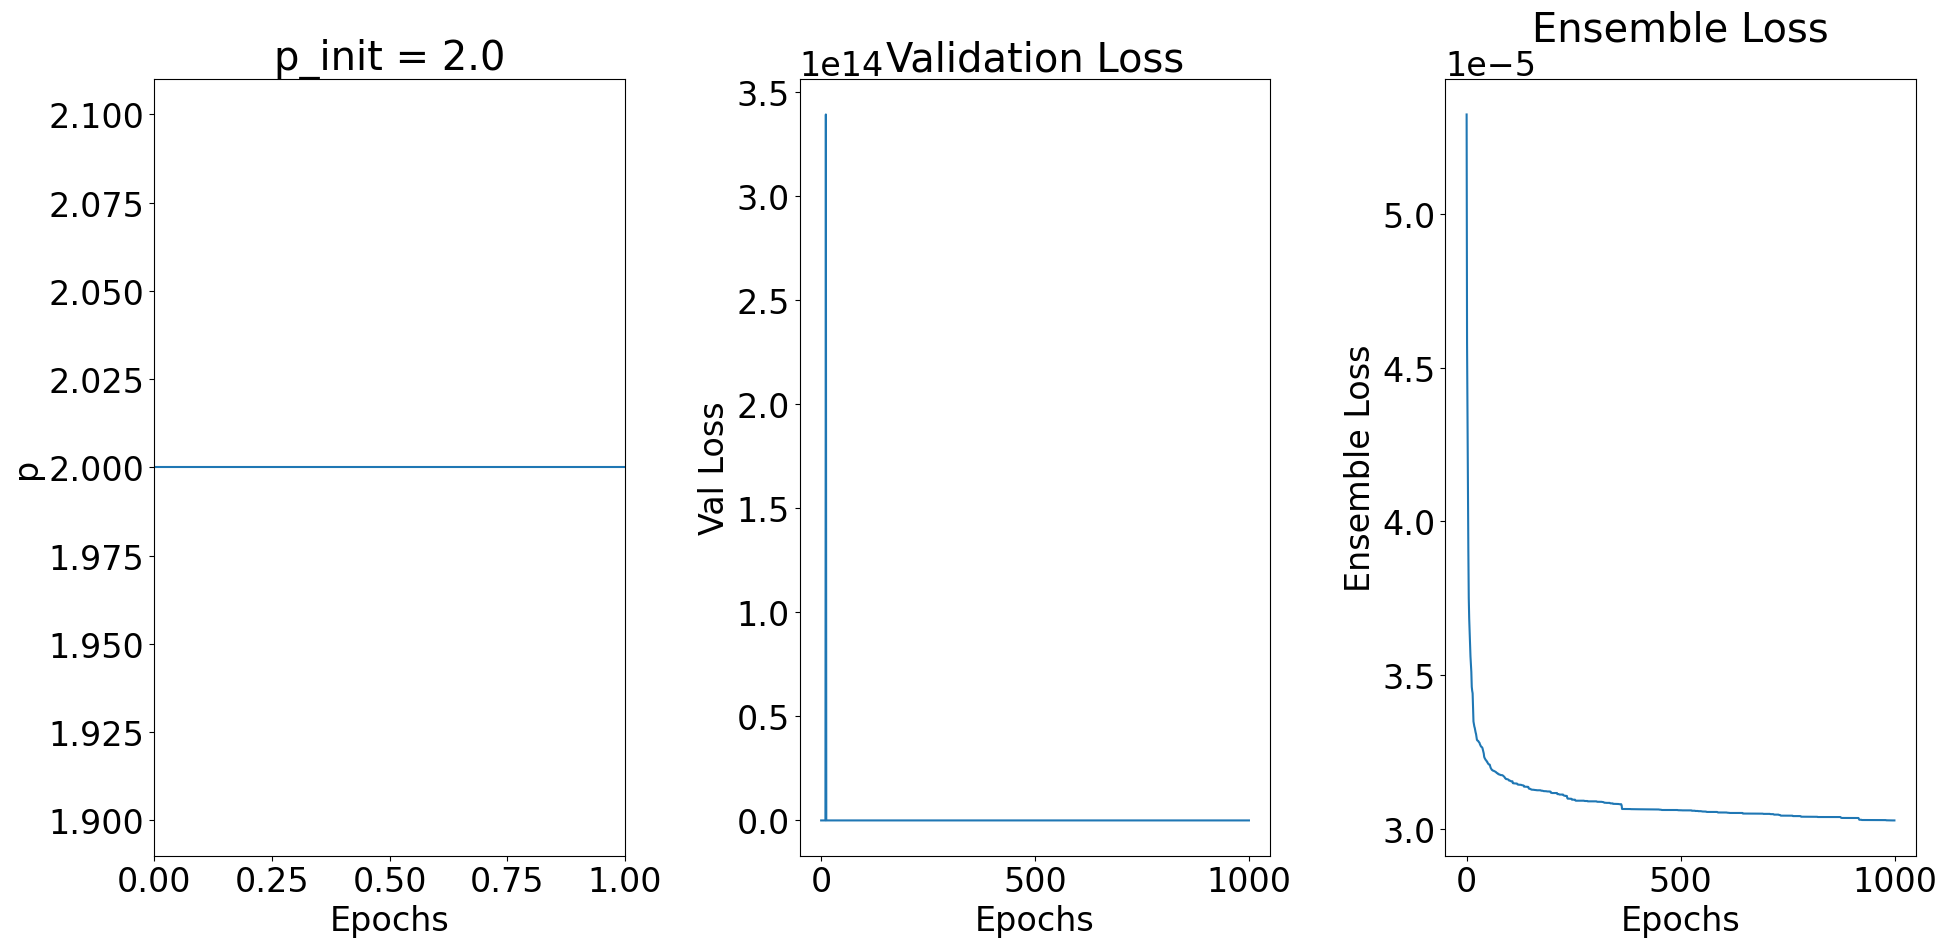

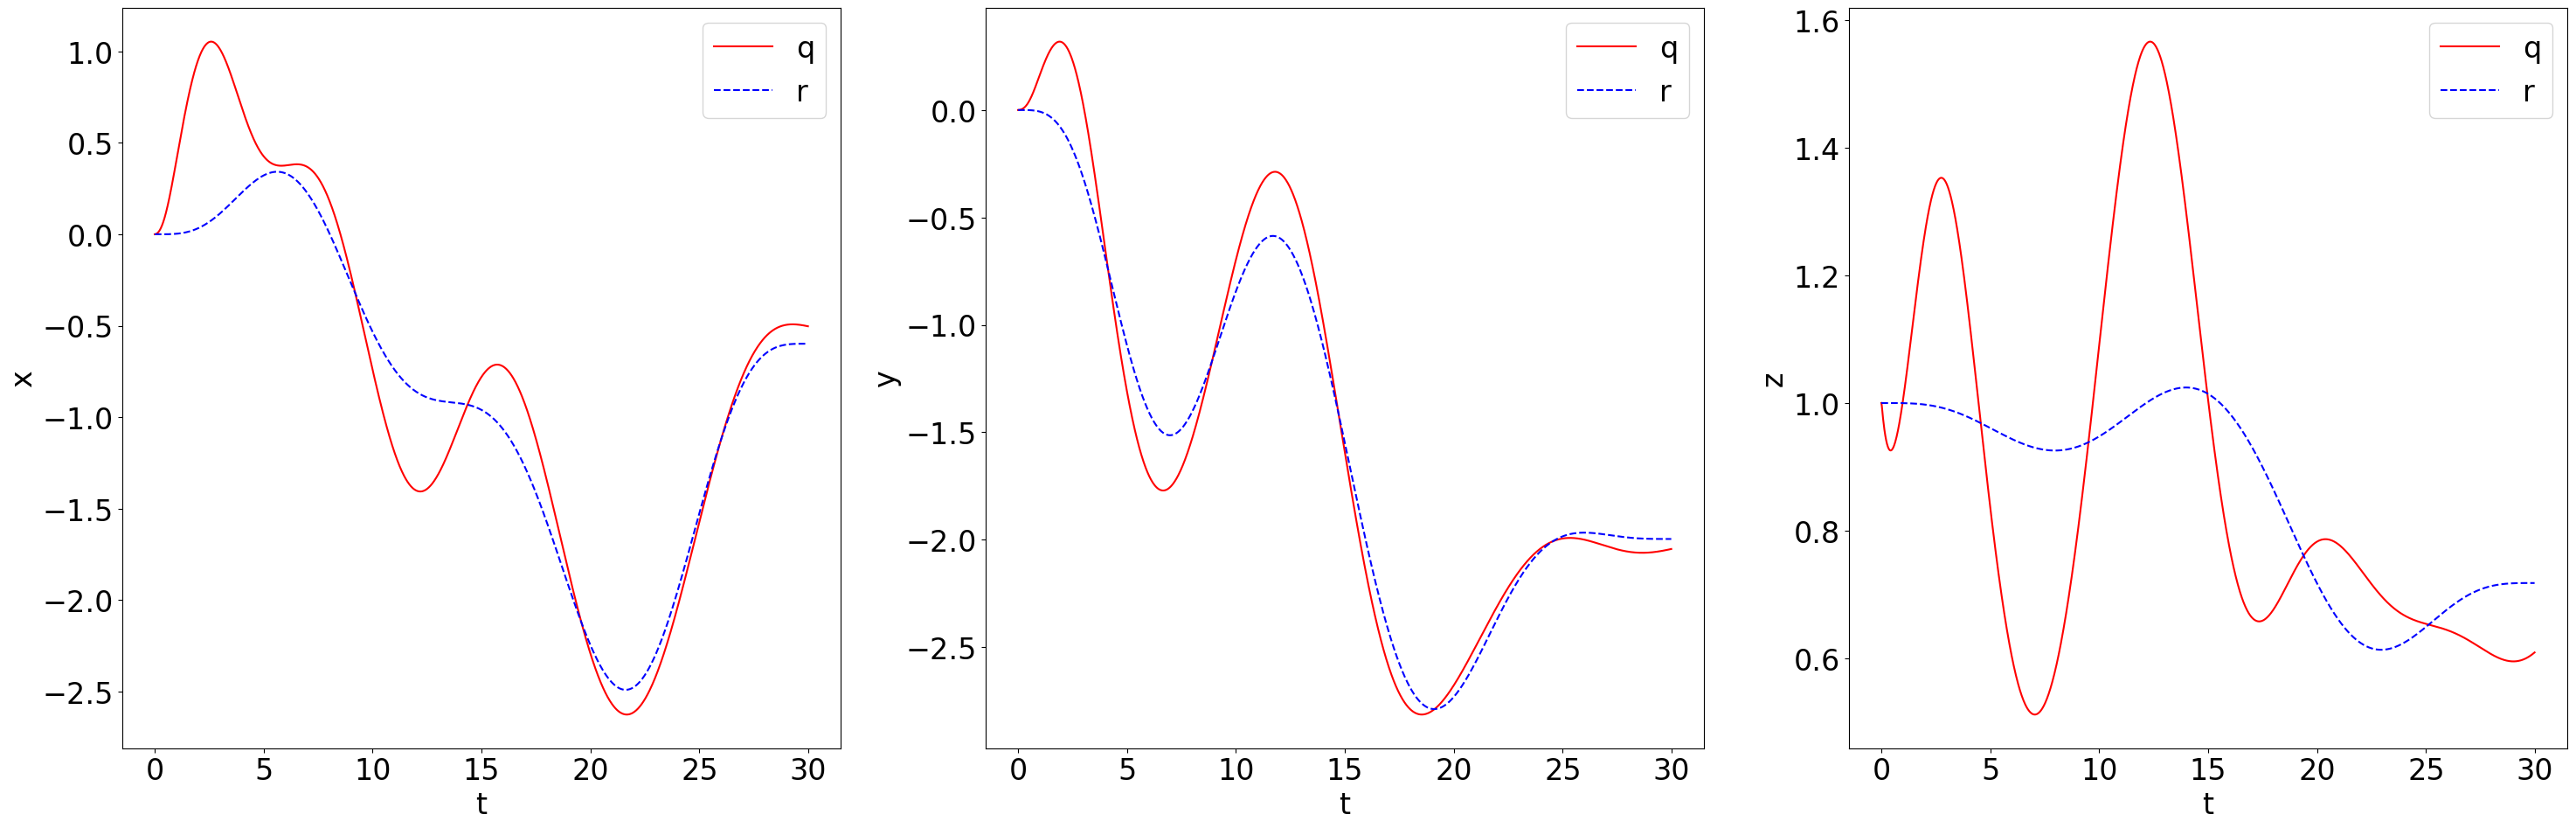

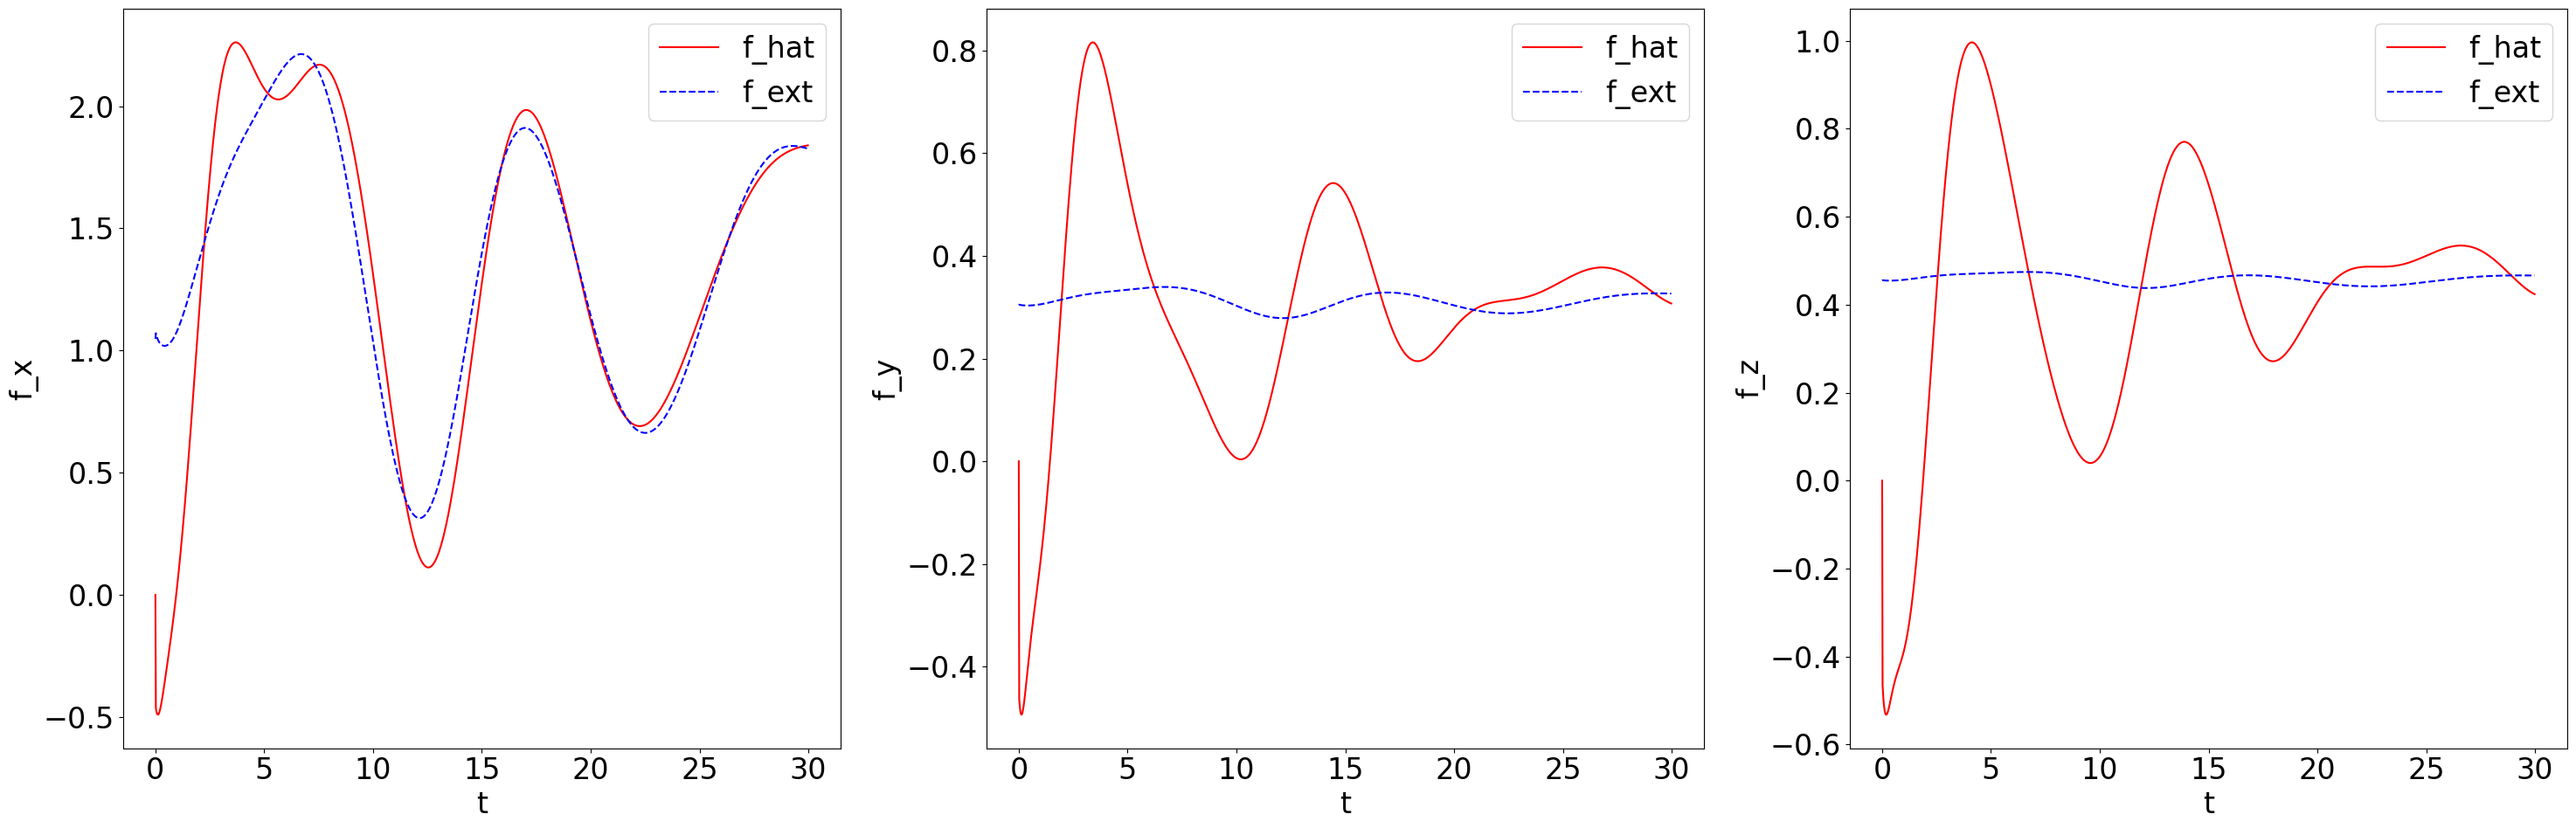

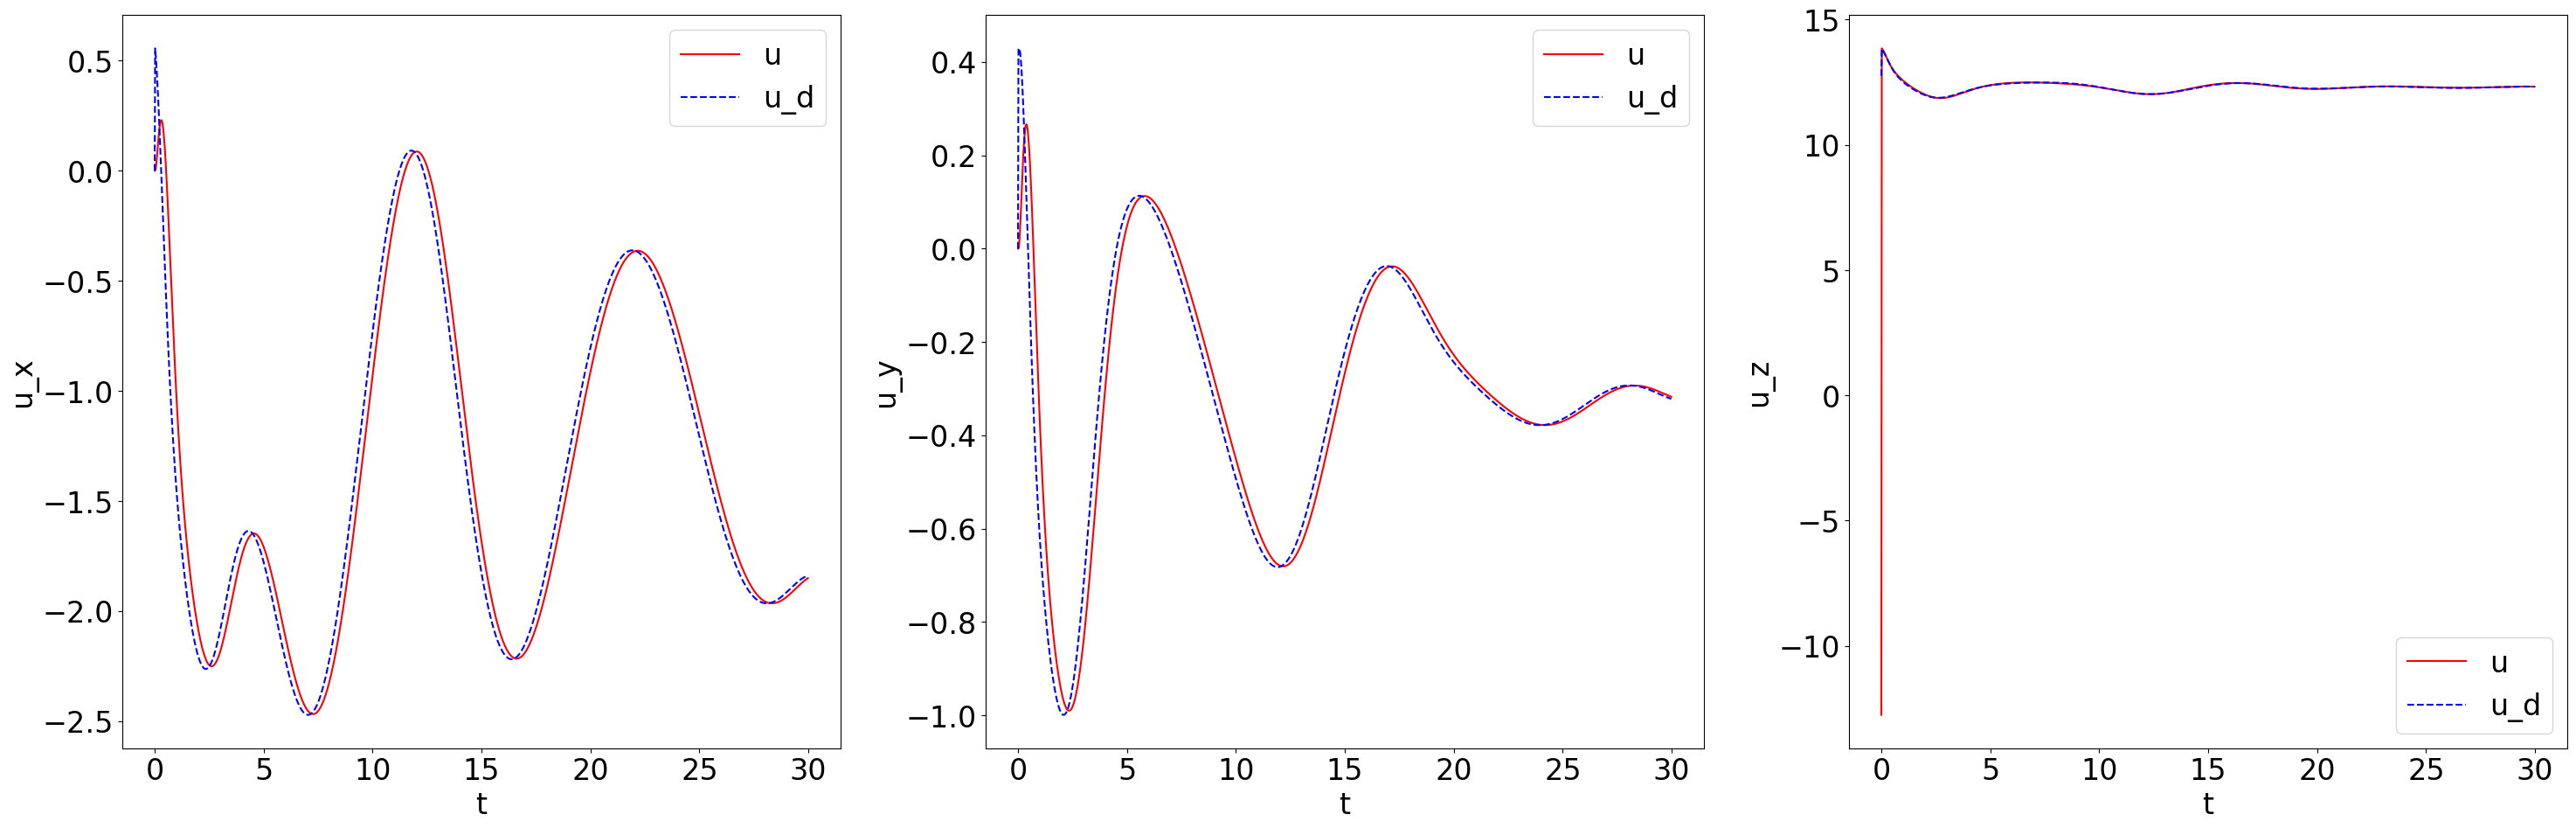

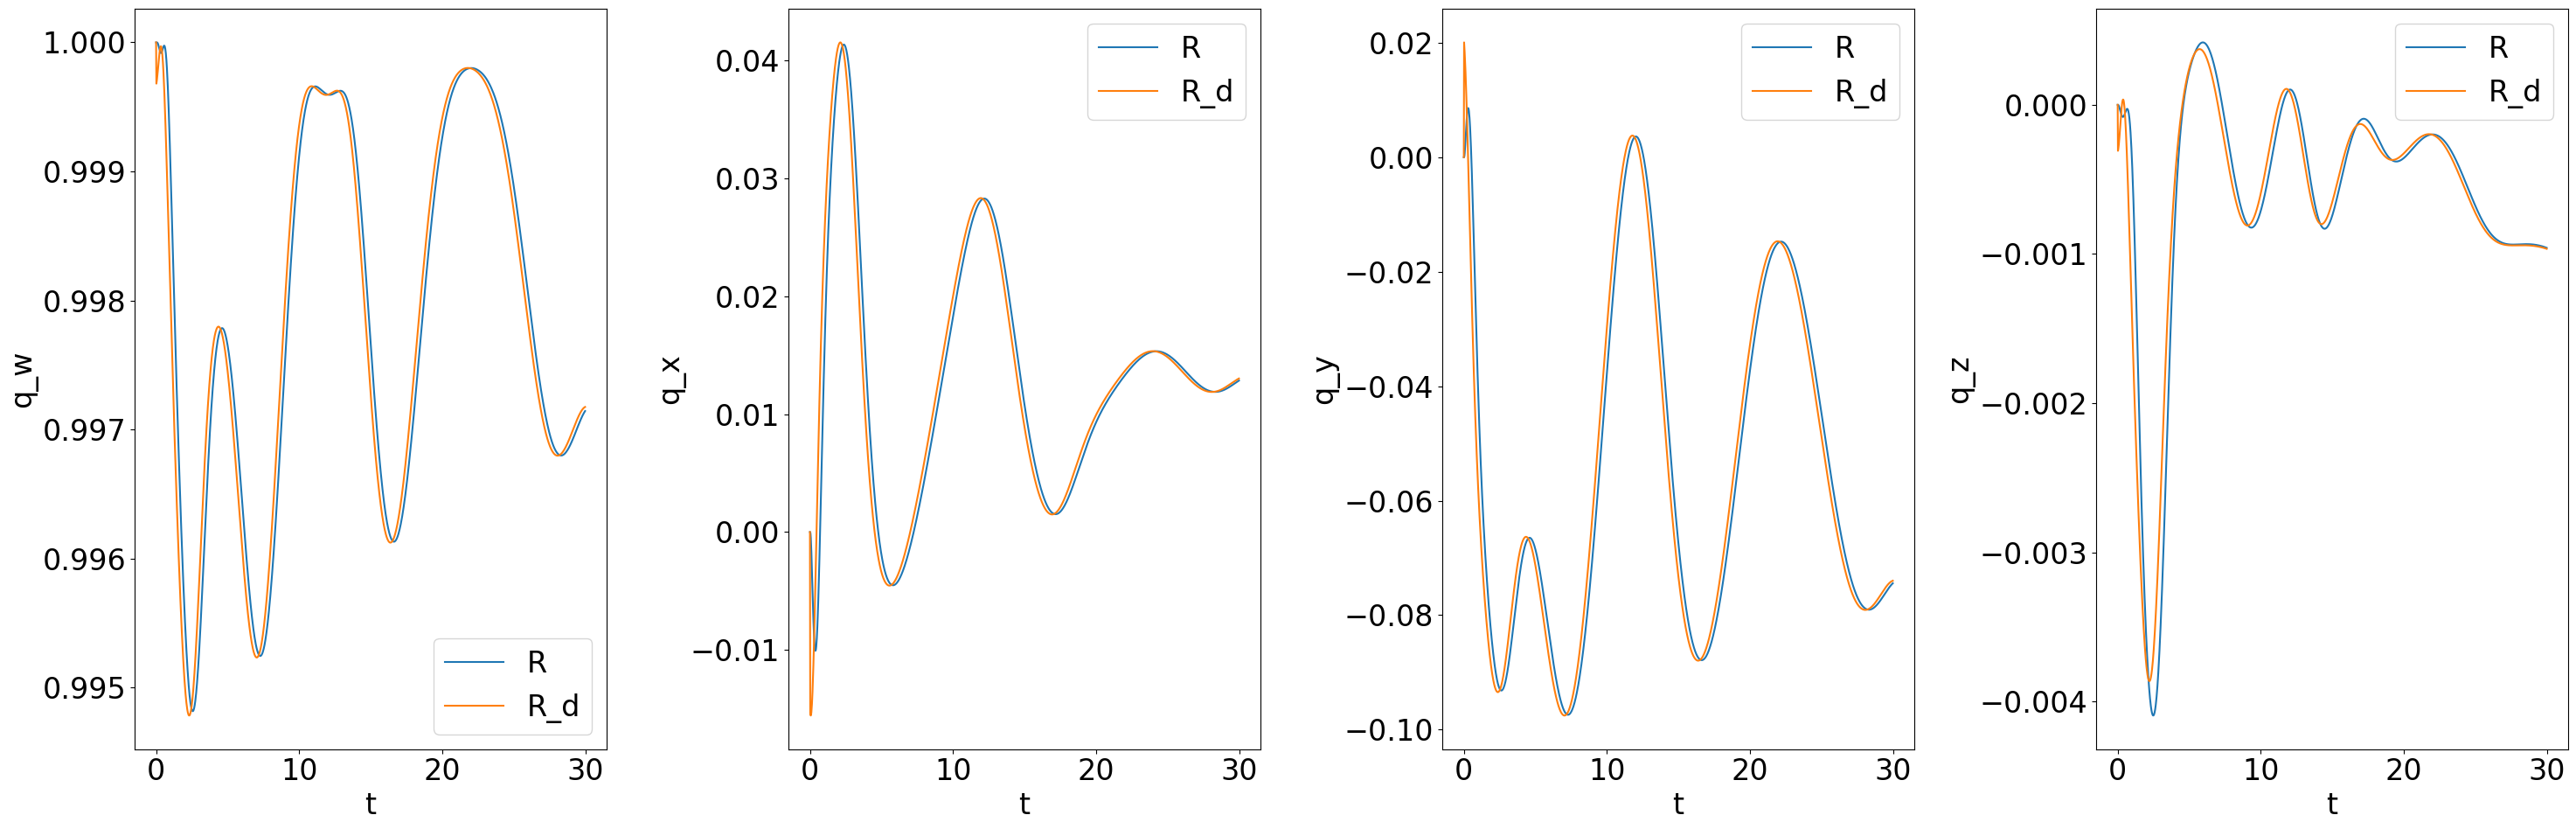

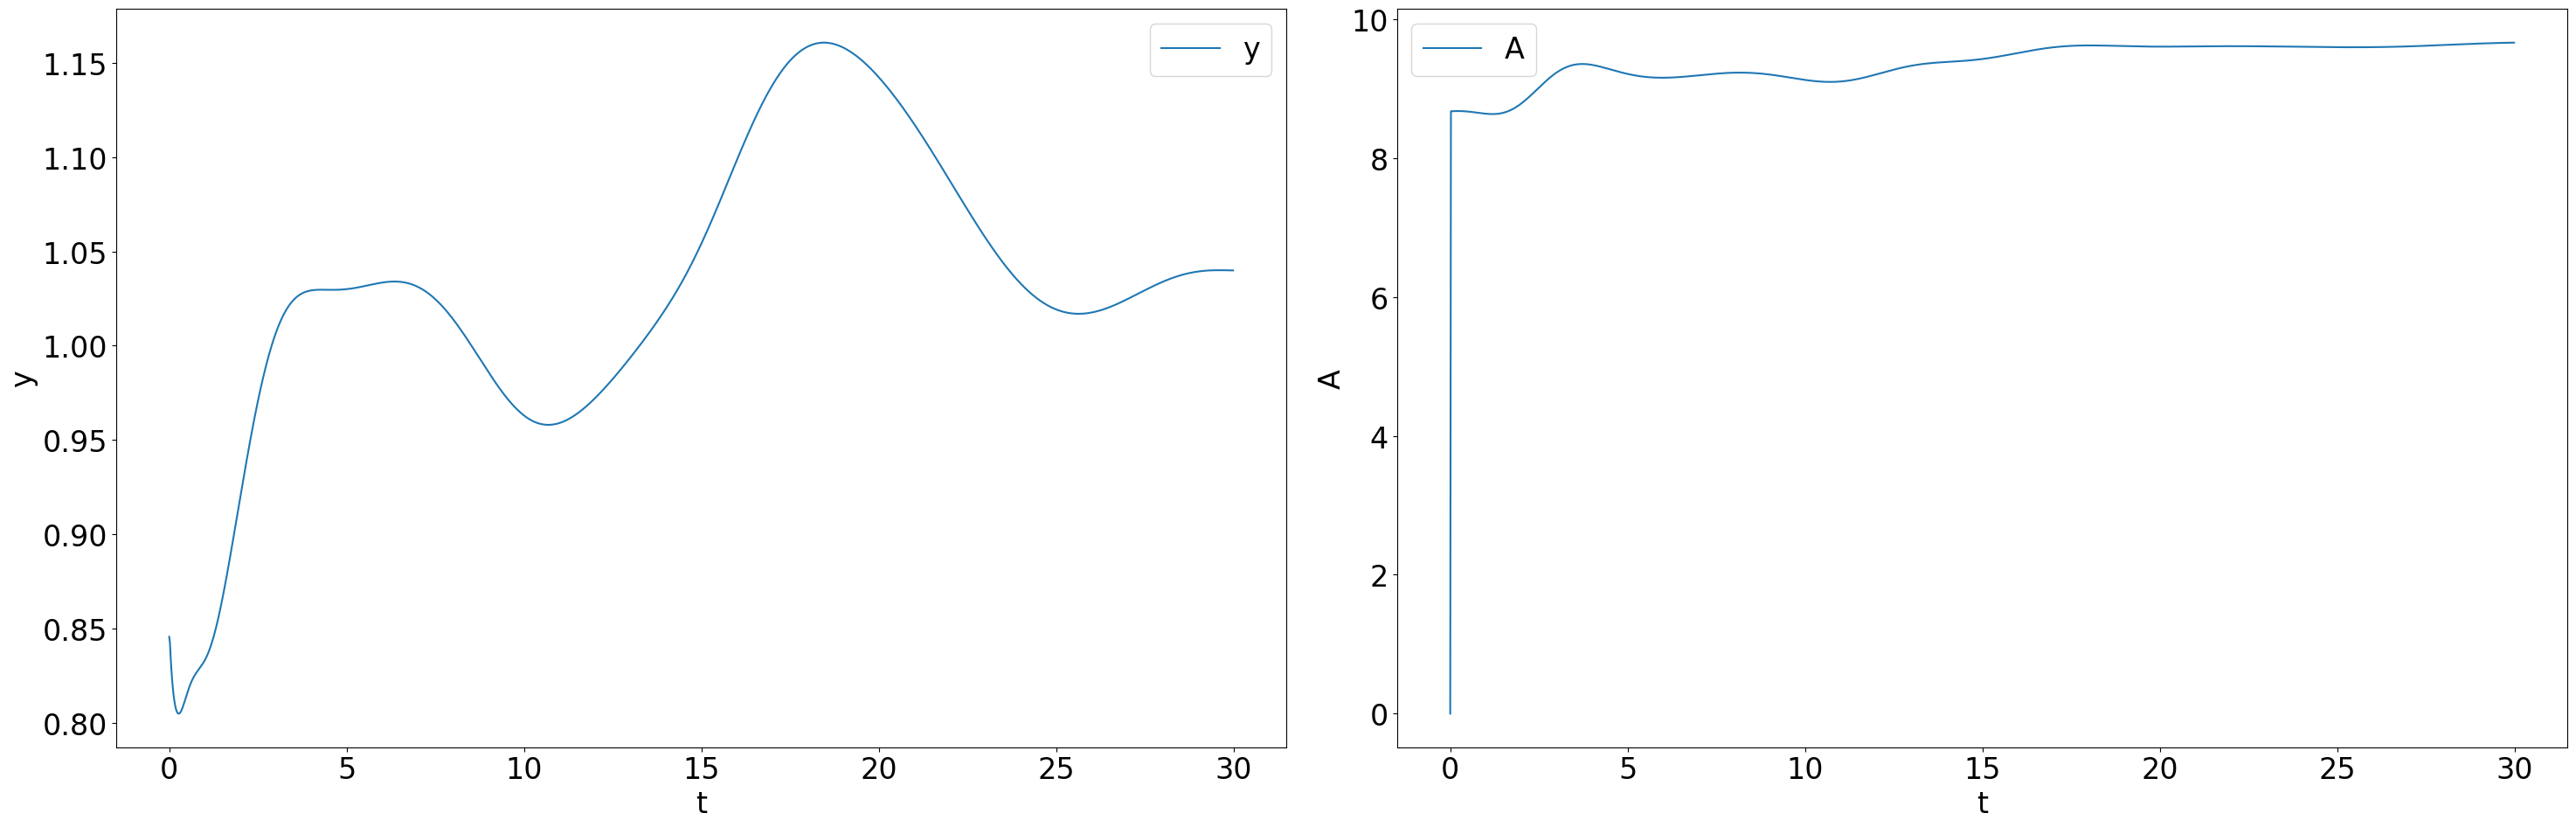

In [592]:
# trial_name = 'hardware_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_reg_P_1e-2'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0100.pkl'
# trial_name = 'hardware_mac_kR_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_ubuntu_kR_reg_P_500'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=500.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_11'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_12'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_13'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
# trial_name = 'hardware_14'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
# trial_name = 'hardware_15'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0000.pkl'
# trial_name = 'hardware_16'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0020.pkl'
# trial_name = 'z_up_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'z_up_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'z_up_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'z_up_reg_P1_kROmega'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'

trial_name = 'reg_P_1e-1_constant_Kr'
filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'reg_P_5e-1_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.5000.pkl'
# trial_name = 'reg_P_1_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'reg_P_5_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=5.0000.pkl'
# trial_name = 'reg_P_10_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'reg_P_100_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'reg_P_1000_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1000.0000.pkl'
# trial_name = 'reg_P_5000_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=5000.0000.pkl'
# trial_name = 'reg_P_10000_constant_Kr'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10000.0000.pkl'

model_dir = f'train_results/{trial_name}'
T_ = 30.0
dt_ = 0.02
w_ = 2.0
pnorm_flag = True
visual_verbose = 6
save_dir = f'test_results/{trial_name}'
controller_type = 'adaptive'
# controller_type = 'pid'
fixed_P = 0.01
fixed_P = None
ts_sim, test_params, aux = eval_single_model(model_dir, filename, T_, dt_, w=w_, pnorm_flag=pnorm_flag, visual_verbose=visual_verbose, save_dir=save_dir, controller_type=controller_type, fixed_P=fixed_P)

Best epoch: 20

Loss at epoch: 999
	Training loss:                    8937.843
	Normalized tracking_loss_norm:    8762.229
	Normalized control_loss_norm:     170.6868
	Normalized l2_penalty_norm:       1.0908705e-06
	Normalized reg_P_penalty_norm:    4.9269323

Eigenvalues of P: [1.2400678  0.9106088  0.93551326 0.8662429  0.6581284  0.6940036
 0.66262394 0.6955389  0.9827821  0.79622024 1.0933512  0.81323975
 0.84520173 0.9371621  0.56908935 0.74380714 0.9075926  1.017654
 1.0688192  0.87457985 1.1195967  1.1109949  1.3400911  0.75500536
 1.3962616  0.61689216 0.6302587  0.84449595 0.7071101  1.0946655
 1.05721    1.3438495 ]


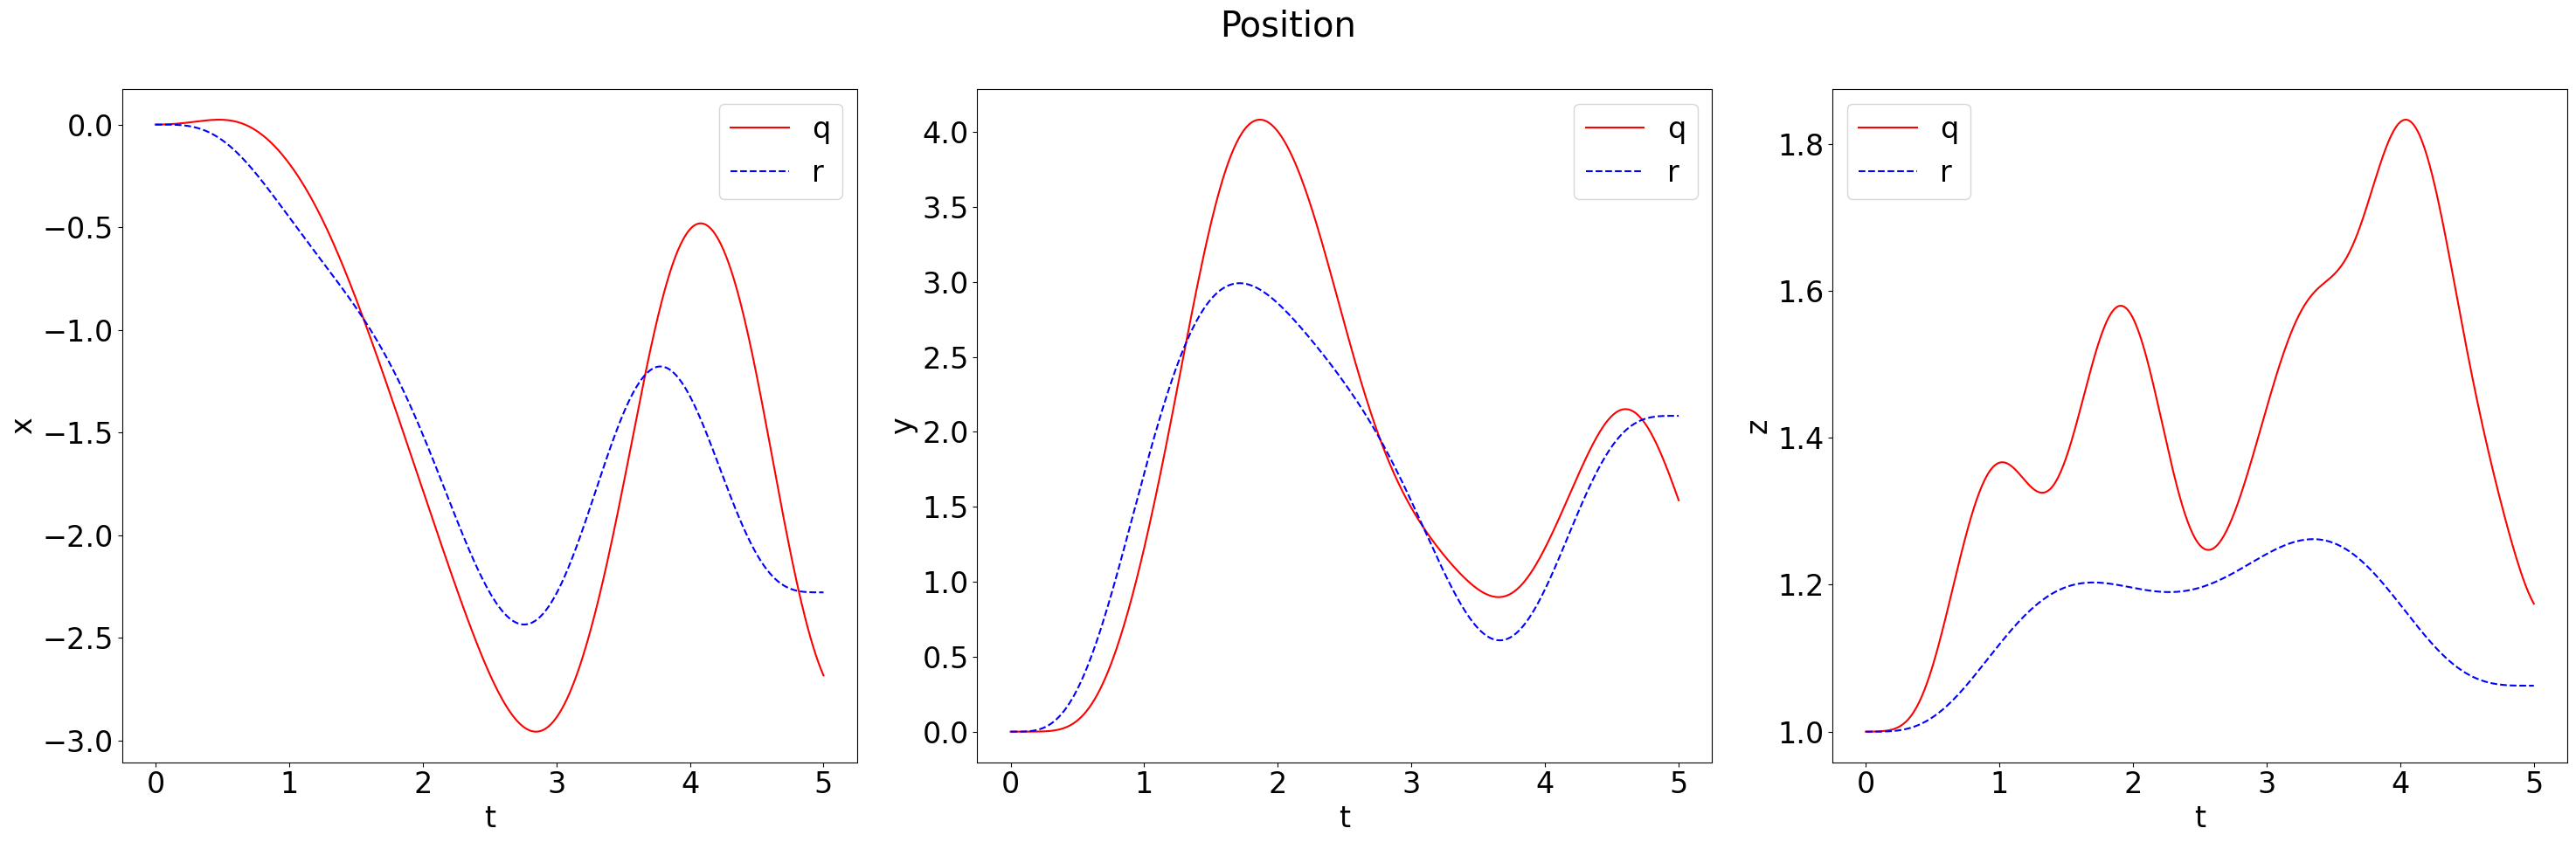

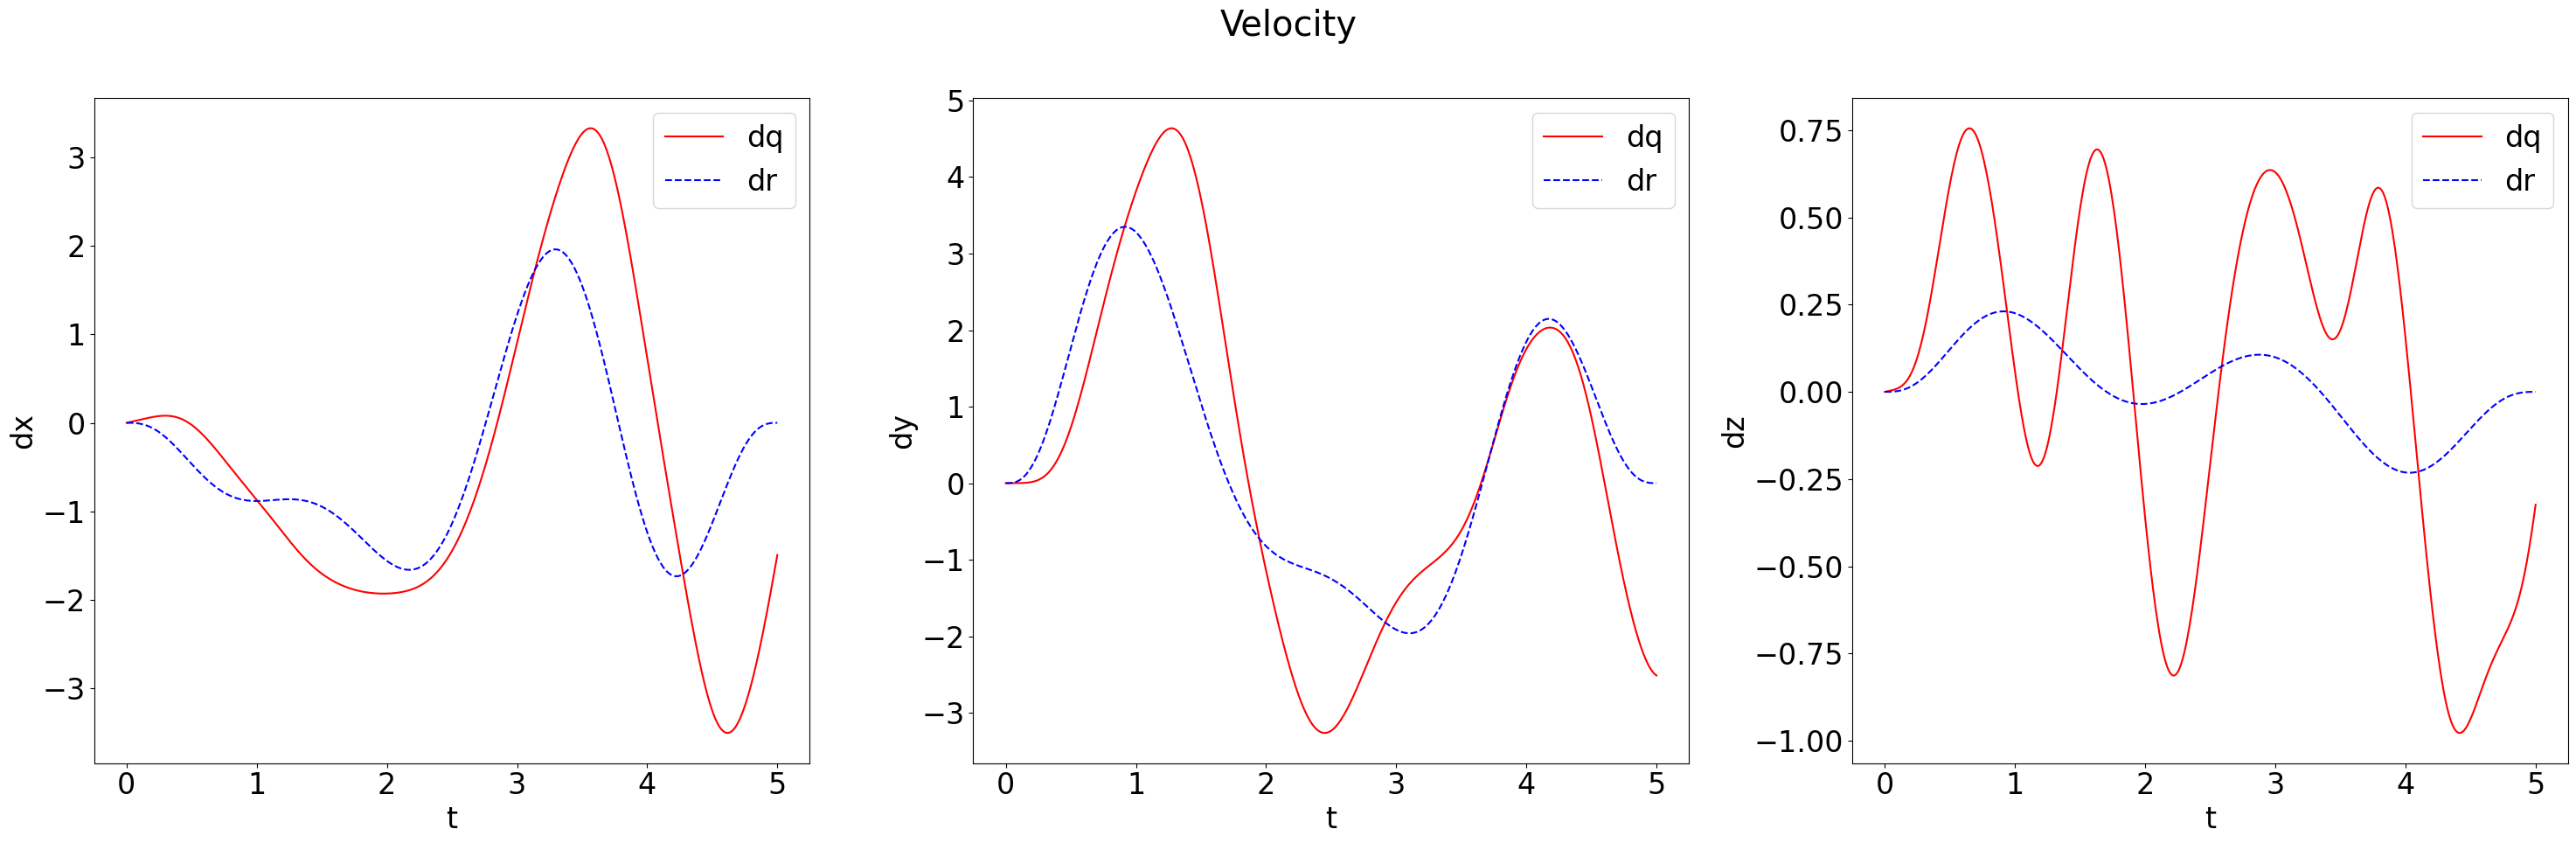

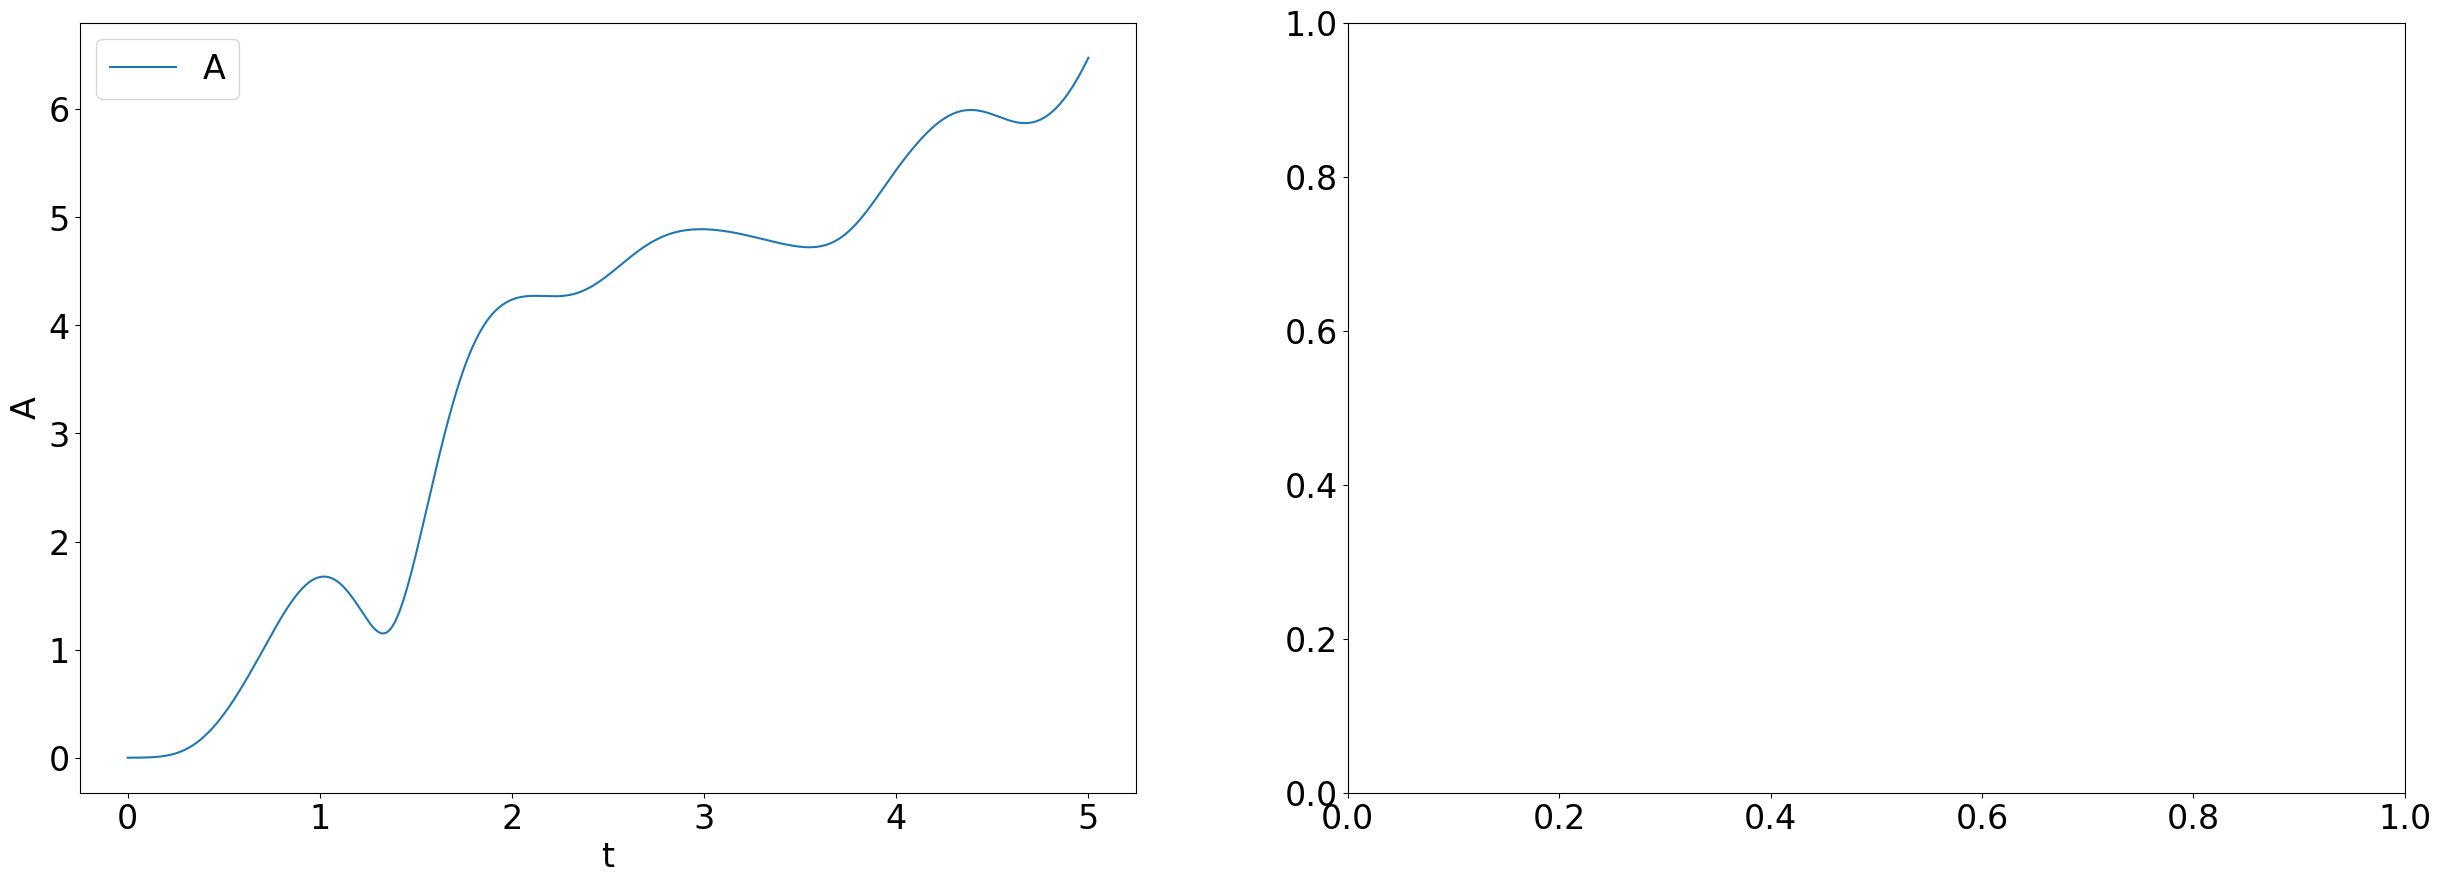

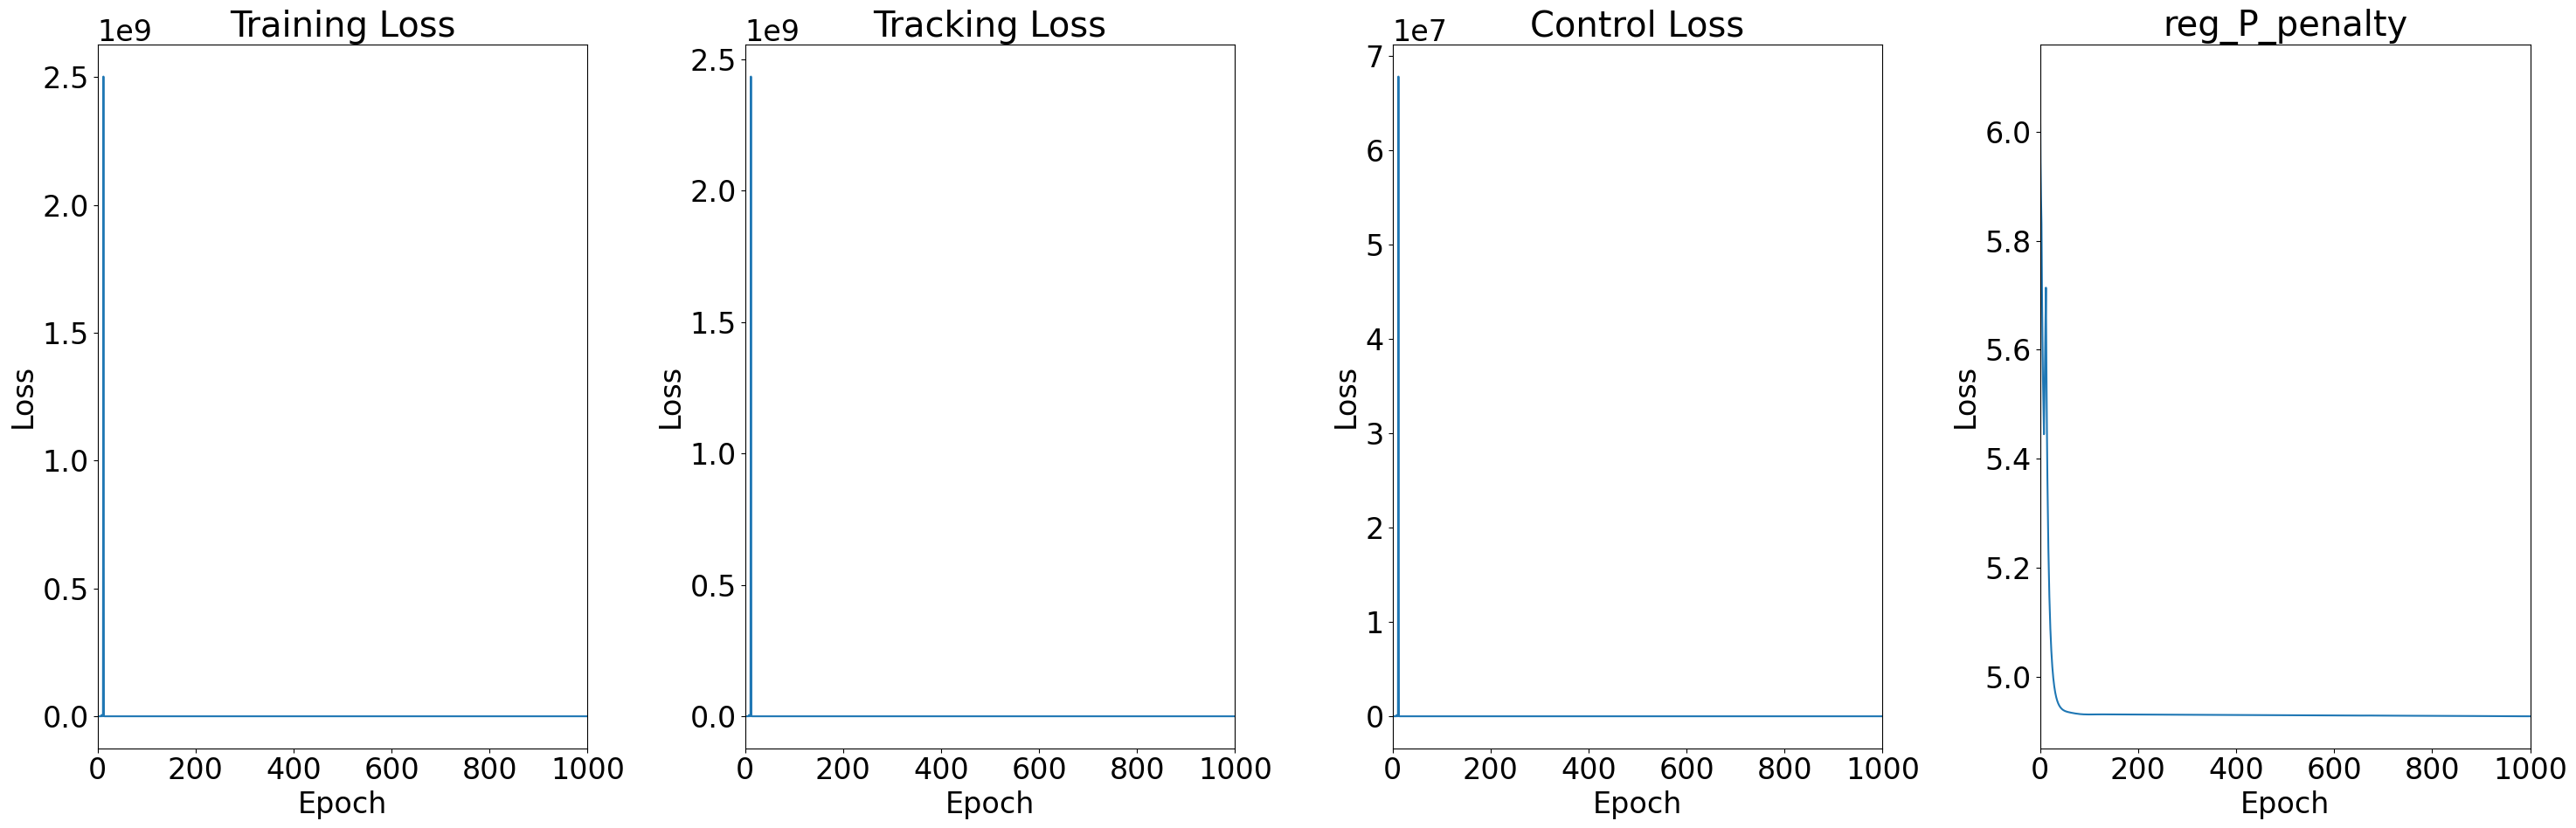

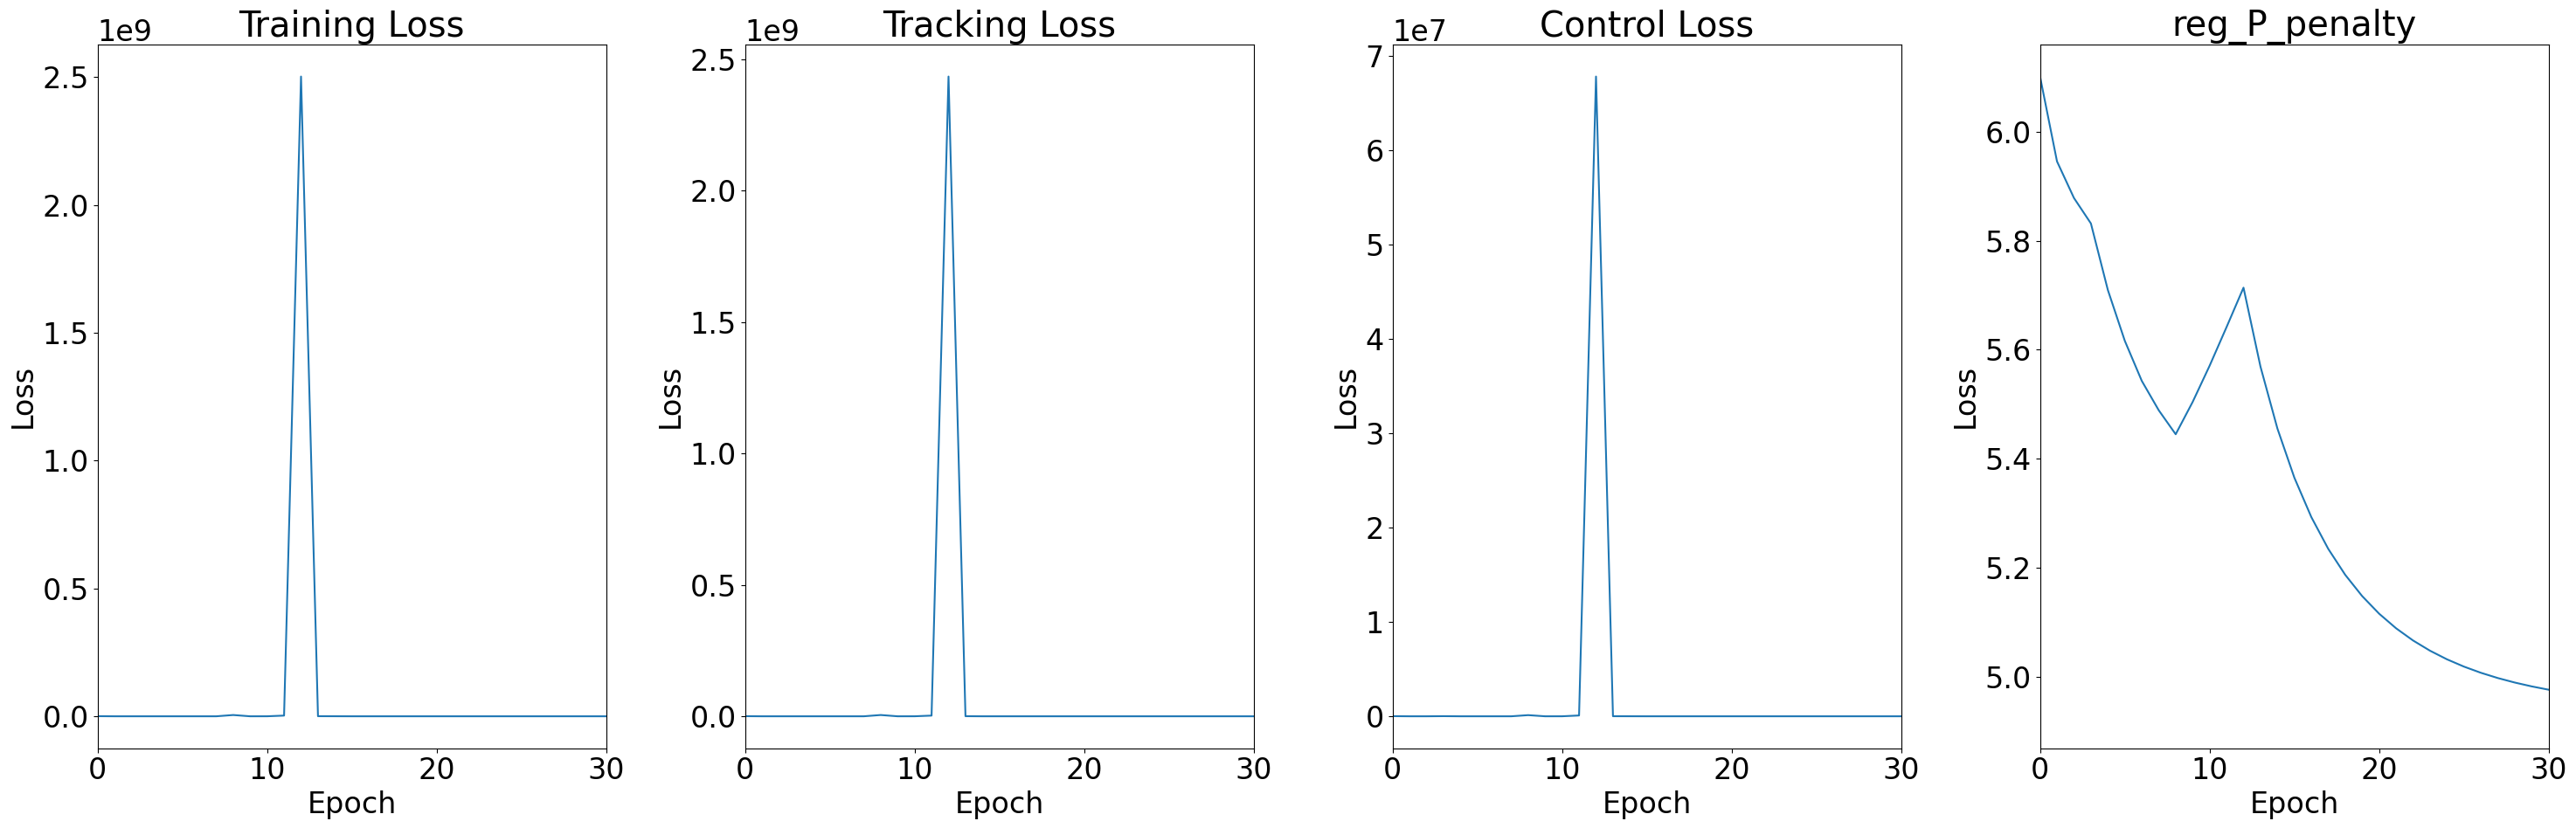

In [593]:
pkl = f'{trial_name}/{filename}'
with open(f'train_results/{pkl}', 'rb') as file:
    raw = pickle.load(file)

print('Best epoch:', raw['best_step_meta'])

validate_model(raw, 999, print_=True, plot=True)
    
E = int(raw['hparams']['ensemble']['num_epochs'])
plot_losses(raw)
plot_losses(raw, xlim=[0,30])
# plot_losses(raw, xlim=[100,E], ylim=[0,0.1])